In [22]:

from tqdm import tqdm
import numpy as np
from sklearn.decomposition import PCA
import random  # Add import for random module
random.seed(10)

class Node:
    def __init__(self, data_indices, depth):
        self.data_indices = data_indices
        self.depth = depth
        self.left = None
        self.right = None
        self.split_dim = None
        self.split_value = None
        self.label = None

def create_data_matrix( X_train ):
    X = X_train.reshape(-1, 784)
    X = X.T
    return X


def center_data(X, mean=None):
    if mean is None:
        mean = np.mean(X, axis=1, keepdims=True)
    X_centered = X - mean
    return X_centered, mean

def apply_pca(X_centered, p):
    covariance_matrix = np.matmul(X_centered, X_centered.T) / (X_centered.shape[1] - 1)
    V, U = np.linalg.eigh(covariance_matrix)

    sorted_indices = np.argsort(V)[::-1]
    U_sorted = U[:, sorted_indices][:, :p]

    Y = U_sorted.T @ X_centered
    return U_sorted, Y

def reconstruct_data(U_sorted, Y):
    X_recon = U_sorted @ Y
    return X_recon

def calculate_mse(X_centered, X_recon):
    mse = np.sum((X_centered - X_recon) ** 2) / X_centered.size
    return mse

def plot_reconstructed_images(X_recon_p, p):
    fig, axes = plt.subplots(10, 5, figsize=(10, 10))
    for i in range(10):
        for j in range(5):
            axes[i, j].imshow(X_recon_p[:, i * 100 + j].reshape(28, 28), cmap='cubehelix_r')
            axes[i, j].axis('off')

    plt.suptitle(f"Reconstructed Images with p={p}")
    plt.show()

def calculate_class_accuracy(y_true, y_pred):

    num_classes = 3
    accuracy_per_class = np.zeros(num_classes)
    total_per_class = np.zeros(num_classes)

    for true_label, pred_label in zip(y_true, y_pred):
        total_per_class[true_label] += 1
        if true_label == pred_label:
            accuracy_per_class[true_label] += 1

    accuracy_per_class = accuracy_per_class / total_per_class
    return accuracy_per_class



def print_tree(root, level=0, prefix="Root:"):
    if root is not None:
        print(" " * (level * 4) + prefix, root.label)
        if root.left is not None or root.right is not None:
            if root.left is not None:
                print_tree(root.left, level + 1, prefix="L--")
            else:
                print(" " * ((level + 1) * 4) + "L--None")
            if root.right is not None:
                print_tree(root.right, level + 1, prefix="R--")
            else:
                print(" " * ((level + 1) * 4) + "R--None")



def weighted_misclassification_loss(y, weight_matrix):
    if len(y) == 0:
        return 0
    counts = np.bincount(y)
    most_frequent_label = np.argmax(counts)
    incorrect_samples = np.sum(weight_matrix[y != most_frequent_label])
    return incorrect_samples,np.sum([y != most_frequent_label])

def find_best_split(X, y, data_indices, weight_matrix):
    n_samples, n_features = X[data_indices].shape
    
    best_loss = float('inf')
    best_split_dim = None
    best_split_value = None
    
    for dim in range(n_features):
        unique_values = np.unique(X[data_indices, dim])
        
        for i in range(len(unique_values) - 1):
            value = (unique_values[i] + unique_values[i + 1]) / 2  # Midpoint split
            left_indices = data_indices[X[data_indices, dim] <= value]
            right_indices = data_indices[X[data_indices, dim] > value]

            loss_left ,l = weighted_misclassification_loss(y[left_indices], weight_matrix[left_indices])
            loss_right ,r= weighted_misclassification_loss(y[right_indices], weight_matrix[right_indices])
            
            # Calculate weighted misclassification loss
            
            loss = ( loss_left + loss_right) / np.sum(weight_matrix)
            
            # print(loss)
            if loss < best_loss:
                # print("Loss ",len(X)-l-r)    
                best_loss = loss
                best_split_dim = dim
                best_split_value = value
                
    return best_split_dim, best_split_value,best_loss
    



def assign_label_for_node(node, y):
    unique_labels, label_counts = np.unique(y[node.data_indices], return_counts=True)
    node.label = unique_labels[np.argmax(label_counts)]
    return node

def check_stopping_criteria(y, data_indices, total_leaf_nodes, max_leaf_nodes):
    if len(np.unique(y[data_indices])) == 1 or (max_leaf_nodes is not None and total_leaf_nodes >= max_leaf_nodes):
        return True
    return False



def grow_tree(X, y, data_indices=None, depth=0, max_depth=1,weight_matrix=None):
    global total_leaf_nodes
    if weight_matrix is None:
        weight_matrix = np.array([1.0/len(X)]*len(X))
    if data_indices is None:
        data_indices = np.arange(X.shape[0])

    n_samples, n_features = X[data_indices].shape

    node= Node(data_indices=data_indices, depth=depth)

    if depth == max_depth or check_stopping_criteria(y, data_indices, total_leaf_nodes, 2):
        assign_label_for_node(node, y)
        total_leaf_nodes += 1
        return node

    best_split_dim, best_split_value,best_loss = find_best_split(X, y, data_indices,weight_matrix)
    
    left_indices = data_indices[X[data_indices, best_split_dim] <= best_split_value]
    right_indices = data_indices[X[data_indices, best_split_dim] > best_split_value]

    node.split_dim = best_split_dim
    node.split_value = best_split_value

    node.left = grow_tree(X, y, left_indices, depth=depth + 1, max_depth=max_depth)
    node.right = grow_tree(X, y, right_indices, depth=depth + 1, max_depth=max_depth)

    return node,best_loss

def predict(x, node):
    if node.label is not None:
        return node.label
    if x[node.split_dim] <= node.split_value:
        return predict(x, node.left)
    else:
        return predict(x, node.right)


import numpy as np

# Load MNIST dataset
mnist_data = np.load(r"D:\Downloads\mnist.npz")
x_train_all, y_train_all = mnist_data['x_train'], mnist_data['y_train']
x_test_all, y_test_all = mnist_data['x_test'], mnist_data['y_test']

# Select classes 0 and 1
selected_train_indices = np.where((y_train_all == 0) | (y_train_all == 1))[0]
selected_test_indices = np.where((y_test_all == 0) | (y_test_all == 1))[0]

x_selected_train = x_train_all[selected_train_indices]
y_selected_train = y_train_all[selected_train_indices]
x_selected_test = x_test_all[selected_test_indices]
y_selected_test = y_test_all[selected_test_indices]

# Sample 1000 samples randomly from each class for validation
num_val_samples_per_class = 1000

# Initialize empty lists to store indices
val_indices = []

# For each class (0 and 1)
for class_label in [0, 1]:
    # Find indices of samples belonging to the current class in the training set
    class_indices_train = np.where(y_selected_train == class_label)[0]

    # Randomly select validation samples
    val_indices.extend(np.random.choice(class_indices_train, size=num_val_samples_per_class, replace=False))

# Convert list to numpy array
val_indices = np.array(val_indices)

# Remove validation samples from the training set
x_train = np.delete(x_selected_train, val_indices, axis=0)
y_train = np.delete(y_selected_train, val_indices)

# Separate validation set
x_val = x_selected_train[val_indices]
y_val = y_selected_train[val_indices]

# Verify shapes
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)

# x_test should contain all samples from the original x_test_all
x_test = x_selected_test
y_test = y_selected_test

# Verify shapes
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

X = create_data_matrix(x_train)
X_centered,X_train_mean = center_data(X)
p = 5
U_sorted, x_reduced = apply_pca(X_centered, p)
x_reduced = x_reduced.T
print(x_reduced.shape)


X = create_data_matrix(x_val)
X_centered_val,X_val_mean = center_data(X,X_train_mean)
p = 5
x_reduced_val = U_sorted.T @ X_centered_val
x_reduced_val = x_reduced_val.T
print(x_reduced_val.shape)



X = create_data_matrix(x_test)
X_centered_test,X_test_mean = center_data(X,X_train_mean)
p = 5
x_reduced_test = U_sorted.T @ X_centered_test
x_reduced_test = x_reduced_test.T
print(x_reduced_test.shape)





# def ada_boost(X, y, num_iterations):
#     weights = np.ones(len(X),dtype=np.float64) / len(X)  # Initialize weights uniformly
#     classifiers = []  # Store the decision trees
#     alphas = []  # Store the alpha values
#     global total_leaf_nodes
#     for _ in tqdm(range(num_iterations)):
#         # Create a decision tree using the weighted dataset
#         total_leaf_nodes = 0
        
        
#         tree,best_loss = grow_tree(X, y, weight_matrix=weights)
#         print(" unique weights " , np.unique(weights))
#         predictions = np.array([predict(x, tree) for x in X])
        
#         accuracy = np.mean(predictions == y)
#         print(f"Iteration {_+1}: Accuracy = {accuracy}")
        
#         print(np.bincount(predictions))
#         misclassified = np.where(predictions != y)[0]
#         weighted_error = np.sum(weights[misclassified]) / np.sum(weights)
#         print(" weighted_error " ,weighted_error )
        
#         # Calculate alpha
#         alpha = np.log((1 - weighted_error) / weighted_error)
#         print("alpha ",alpha)
#         alphas.append(alpha)
#         classifiers.append((tree,alpha))
        

#         predictions = ada_boost_predict(classifiers, X,y)
#         accuracy = np.mean(predictions == y)
#         print(f"Iteration {_+1}: Accuracy = {accuracy}")

#         # Update weights
#         weights[misclassified] *= np.exp(alpha)

       
#     return classifiers
def ada_boost(X, y, X_val, y_val, num_iterations):
    
    weights = np.ones(len(X), dtype=np.float64) / len(X)  # Initialize weights uniformly
    classifiers = []  # Store the decision trees
    alphas = []  # Store the alpha values
    val_accuracies = []  # Store validation accuracies
    
    global total_leaf_nodes
    for i in tqdm(range(num_iterations)):
        # Create a decision tree using the weighted dataset
        total_leaf_nodes = 0
        tree, best_loss = grow_tree(X, y, weight_matrix=weights)
        print_tree(tree)
        predictions = np.array([predict(x, tree) for x in X])
        accuracy = np.mean(predictions == y)
        print(f"Iteration {i+1}: Training Accuracy  of Tree= {accuracy}")

        misclassified = np.where(predictions != y)[0]
        weighted_error = np.sum(weights[misclassified]) / np.sum(weights)

        # Calculate alpha
        alpha = np.log((1 - weighted_error) / weighted_error)
        alphas.append(alpha)
        classifiers.append((tree, alpha))
        print('alpha ', alpha)
        print('weighted_error ',weighted_error)
        # Update weights
        weights[misclassified] *= np.exp(alpha)

        # Calculate validation accuracy
        val_predictions = ada_boost_predict(classifiers, X_val, y_val)
        val_accuracy = np.mean(val_predictions == y_val)
        val_accuracies.append(val_accuracy)
        print(f"Iteration {i+1}: Validation Accuracy ADA Boost= {val_accuracy}")

    return classifiers, val_accuracies

def ada_boost_predict(classifiers, X,y):
    predictions = np.zeros(len(X))
    
    for tree, alpha in classifiers:
        prediction = np.array([predict(x, tree) for x in X],dtype = np.int64)
        # prediction[prediction == 0] = -1  # Change 0 to -1
        
        
        predictions += (alpha * ((prediction * 2 )- 1))
    
    print(((prediction * 2 )- 1)[980:1020])
    
    # # Final prediction based on the sign
    final_prediction = np.sign(predictions)
    final_prediction = (final_prediction+1)/2
   # print(final_prediction[980:1020])
    
    return final_prediction


# Example usage:
num_iterations = 300
classifiers,val_accuracies = ada_boost(x_reduced, y_train,x_reduced_val,y_val, num_iterations)#

# Example usage:
# predictions = ada_boost_predict(classifiers, x_val)


Shapes:
x_train: (10665, 28, 28)
y_train: (10665,)
x_val: (2000, 28, 28)
y_val: (2000,)
x_test: (2115, 28, 28)
y_test: (2115,)
(10665, 5)
(2000, 5)
(2115, 5)


  0%|▎                                                                               | 1/300 [00:18<1:34:33, 18.98s/it]

Root: None
    L-- 0
    R-- 1
Iteration 1: Training Accuracy  of Tree= 0.9952180028129395
alpha  5.338103530663514
weighted_error  0.00478199718706048
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 1: Validation Accuracy ADA Boost= 0.996


  1%|▌                                                                               | 2/300 [00:38<1:34:50, 19.09s/it]

Root: None
    L-- 0
    R-- 1
Iteration 2: Training Accuracy  of Tree= 0.9648382559774965
alpha  1.0377431101139556
weighted_error  0.2615856970261253
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 2: Validation Accuracy ADA Boost= 0.996


  1%|▊                                                                               | 3/300 [00:57<1:34:42, 19.13s/it]

Root: None
    L-- 0
    R-- 1
Iteration 3: Training Accuracy  of Tree= 0.9718706047819972
alpha  1.507289013688549
weighted_error  0.181340908749756
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 3: Validation Accuracy ADA Boost= 0.996


  1%|█                                                                               | 4/300 [01:16<1:33:36, 18.97s/it]

Root: None
    L-- 1
    R-- 0
Iteration 4: Training Accuracy  of Tree= 0.5684950773558368
alpha  1.2447299885009833
weighted_error  0.22361373603556242
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1  1  1 -1 -1  1]
Iteration 4: Validation Accuracy ADA Boost= 0.996


  2%|█▎                                                                              | 5/300 [01:34<1:32:57, 18.91s/it]

Root: None
    L-- 0
    R-- 1
Iteration 5: Training Accuracy  of Tree= 0.6345991561181434
alpha  1.254473827289608
weighted_error  0.22192665876833648
[ 1  1  1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1  1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1]
Iteration 5: Validation Accuracy ADA Boost= 0.996


  2%|█▌                                                                              | 6/300 [01:53<1:32:59, 18.98s/it]

Root: None
    L-- 0
    R-- 1
Iteration 6: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.8230766538736336
weighted_error  0.3051109622353089
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 6: Validation Accuracy ADA Boost= 0.996


  2%|█▊                                                                              | 7/300 [02:12<1:32:23, 18.92s/it]

Root: None
    L-- 0
    R-- 1
Iteration 7: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.9625715903816977
weighted_error  0.2763636151763305
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 7: Validation Accuracy ADA Boost= 0.996


  3%|██▏                                                                             | 8/300 [02:31<1:32:22, 18.98s/it]

Root: None
    L-- 0
    R-- 1
Iteration 8: Training Accuracy  of Tree= 0.7127051101734646
alpha  0.9069298910979936
weighted_error  0.28762848709112016
[ 1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 8: Validation Accuracy ADA Boost= 0.996


  3%|██▍                                                                             | 9/300 [02:50<1:31:25, 18.85s/it]

Root: None
    L-- 1
    R-- 0
Iteration 9: Training Accuracy  of Tree= 0.606938584153774
alpha  0.7537878679646992
weighted_error  0.31999650413809116
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 9: Validation Accuracy ADA Boost= 0.996


  3%|██▋                                                                            | 10/300 [03:08<1:30:19, 18.69s/it]

Root: None
    L-- 0
    R-- 1
Iteration 10: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.8241748594750299
weighted_error  0.3048781724383142
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 10: Validation Accuracy ADA Boost= 0.9965


  4%|██▉                                                                            | 11/300 [03:27<1:29:51, 18.66s/it]

Root: None
    L-- 0
    R-- 1
Iteration 11: Training Accuracy  of Tree= 0.5385841537740272
alpha  0.6411250220720919
weighted_error  0.3449922709122504
[-1 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1]
Iteration 11: Validation Accuracy ADA Boost= 0.996


  4%|███▏                                                                           | 12/300 [03:45<1:29:22, 18.62s/it]

Root: None
    L-- 1
    R-- 0
Iteration 12: Training Accuracy  of Tree= 0.6027191748710736
alpha  0.5896277113800299
weighted_error  0.35672027916065374
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 12: Validation Accuracy ADA Boost= 0.996


  4%|███▍                                                                           | 13/300 [04:04<1:28:49, 18.57s/it]

Root: None
    L-- 0
    R-- 1
Iteration 13: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.6095335335898381
weighted_error  0.3521656125553865
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 13: Validation Accuracy ADA Boost= 0.996


  5%|███▋                                                                           | 14/300 [04:22<1:28:19, 18.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 14: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.4788700804525788
weighted_error  0.3825189747527423
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 14: Validation Accuracy ADA Boost= 0.996


  5%|███▉                                                                           | 15/300 [04:41<1:27:38, 18.45s/it]

Root: None
    L-- 1
    R-- 0
Iteration 15: Training Accuracy  of Tree= 0.6262541022034693
alpha  0.44665706240264735
weighted_error  0.39015587275472324
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 15: Validation Accuracy ADA Boost= 0.996


  5%|████▏                                                                          | 16/300 [04:59<1:27:17, 18.44s/it]

Root: None
    L-- 1
    R-- 0
Iteration 16: Training Accuracy  of Tree= 0.6067510548523207
alpha  0.4879666592128669
weighted_error  0.38037268762846493
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 16: Validation Accuracy ADA Boost= 0.9965


  6%|████▍                                                                          | 17/300 [05:18<1:27:16, 18.50s/it]

Root: None
    L-- 0
    R-- 1
Iteration 17: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.5643284893091576
weighted_error  0.36254652356280515
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 17: Validation Accuracy ADA Boost= 0.9965


  6%|████▋                                                                          | 18/300 [05:37<1:27:57, 18.72s/it]

Root: None
    L-- 1
    R-- 0
Iteration 18: Training Accuracy  of Tree= 0.6027191748710736
alpha  0.2901291580495834
weighted_error  0.4279722473335659
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 18: Validation Accuracy ADA Boost= 0.9965


  6%|█████                                                                          | 19/300 [05:55<1:27:11, 18.62s/it]

Root: None
    L-- 1
    R-- 0
Iteration 19: Training Accuracy  of Tree= 0.5828410689170183
alpha  0.4522235811566675
weighted_error  0.38883221995589995
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 19: Validation Accuracy ADA Boost= 0.9965


  7%|█████▎                                                                         | 20/300 [06:16<1:29:21, 19.15s/it]

Root: None
    L-- 0
    R-- 1
Iteration 20: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.41366891241046927
weighted_error  0.39803271192567286
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 20: Validation Accuracy ADA Boost= 0.9965


  7%|█████▌                                                                         | 21/300 [06:36<1:31:09, 19.60s/it]

Root: None
    L-- 1
    R-- 0
Iteration 21: Training Accuracy  of Tree= 0.5593061415846226
alpha  0.3725430000569127
weighted_error  0.40792668631260776
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 21: Validation Accuracy ADA Boost= 0.9965


  7%|█████▊                                                                         | 22/300 [06:56<1:31:37, 19.77s/it]

Root: None
    L-- 1
    R-- 0
Iteration 22: Training Accuracy  of Tree= 0.5533052039381153
alpha  0.3452768953748858
weighted_error  0.4145282282748278
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 22: Validation Accuracy ADA Boost= 0.9965


  8%|██████                                                                         | 23/300 [07:17<1:32:07, 19.95s/it]

Root: None
    L-- 1
    R-- 0
Iteration 23: Training Accuracy  of Tree= 0.6346929207688702
alpha  0.2916015471339797
weighted_error  0.4276118271015628
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 23: Validation Accuracy ADA Boost= 0.9965


  8%|██████▎                                                                        | 24/300 [07:37<1:31:48, 19.96s/it]

Root: None
    L-- 0
    R-- 1
Iteration 24: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.36727452488425455
weighted_error  0.4091997562370046
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 24: Validation Accuracy ADA Boost= 0.9965


  8%|██████▌                                                                        | 25/300 [07:57<1:31:57, 20.06s/it]

Root: None
    L-- 0
    R-- 1
Iteration 25: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.31442968100613555
weighted_error  0.4220338738672634
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 25: Validation Accuracy ADA Boost= 0.9965


  9%|██████▊                                                                        | 26/300 [08:17<1:31:57, 20.14s/it]

Root: None
    L-- 0
    R-- 1
Iteration 26: Training Accuracy  of Tree= 0.7127051101734646
alpha  0.3154879351121971
weighted_error  0.4217757644879565
[ 1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 26: Validation Accuracy ADA Boost= 0.9965


  9%|███████                                                                        | 27/300 [08:34<1:27:07, 19.15s/it]

Root: None
    L-- 1
    R-- 0
Iteration 27: Training Accuracy  of Tree= 0.606375996249414
alpha  0.20369290619857405
weighted_error  0.4492521164250727
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 27: Validation Accuracy ADA Boost= 0.9965


  9%|███████▎                                                                       | 28/300 [08:48<1:19:46, 17.60s/it]

Root: None
    L-- 1
    R-- 0
Iteration 28: Training Accuracy  of Tree= 0.5592123769338959
alpha  0.3097069301254204
weighted_error  0.4231862755113413
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 28: Validation Accuracy ADA Boost= 0.9965


 10%|███████▋                                                                       | 29/300 [09:02<1:14:13, 16.43s/it]

Root: None
    L-- 0
    R-- 1
Iteration 29: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.2717491446740249
weighted_error  0.43247773306447324
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 29: Validation Accuracy ADA Boost= 0.9965


 10%|███████▉                                                                       | 30/300 [09:16<1:10:11, 15.60s/it]

Root: None
    L-- 0
    R-- 1
Iteration 30: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.3079933334661084
weighted_error  0.4236046188223016
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 30: Validation Accuracy ADA Boost= 0.9965


 10%|████████▏                                                                      | 31/300 [09:29<1:07:32, 15.06s/it]

Root: None
    L-- 0
    R-- 1
Iteration 31: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.25974513110195746
weighted_error  0.4354263616492003
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 31: Validation Accuracy ADA Boost= 0.9965


 11%|████████▍                                                                      | 32/300 [09:43<1:05:46, 14.73s/it]

Root: None
    L-- 1
    R-- 0
Iteration 32: Training Accuracy  of Tree= 0.5403656821378341
alpha  0.24536525266157083
weighted_error  0.438964595188784
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1]
Iteration 32: Validation Accuracy ADA Boost= 0.9965


 11%|████████▋                                                                      | 33/300 [09:57<1:04:25, 14.48s/it]

Root: None
    L-- 1
    R-- 0
Iteration 33: Training Accuracy  of Tree= 0.606375996249414
alpha  0.28502900941156734
weighted_error  0.4292212810643574
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 33: Validation Accuracy ADA Boost= 0.9965


 11%|████████▉                                                                      | 34/300 [10:11<1:03:45, 14.38s/it]

Root: None
    L-- 1
    R-- 0
Iteration 34: Training Accuracy  of Tree= 0.6484763244256915
alpha  0.26064677791712454
weighted_error  0.4352047225109425
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 34: Validation Accuracy ADA Boost= 0.9965


 12%|█████████▏                                                                     | 35/300 [10:25<1:02:30, 14.15s/it]

Root: None
    L-- 0
    R-- 1
Iteration 35: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.2650753936758508
weighted_error  0.43411647585027685
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 35: Validation Accuracy ADA Boost= 0.9965


 12%|█████████▍                                                                     | 36/300 [10:39<1:01:38, 14.01s/it]

Root: None
    L-- 0
    R-- 1
Iteration 36: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.24030661226679223
weighted_error  0.4402107923435587
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 36: Validation Accuracy ADA Boost= 0.9965


 12%|█████████▋                                                                     | 37/300 [10:53<1:01:10, 13.95s/it]

Root: None
    L-- 1
    R-- 0
Iteration 37: Training Accuracy  of Tree= 0.5663384903891233
alpha  0.22479453842865152
weighted_error  0.44403683078460304
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1 -1 -1  1]
Iteration 37: Validation Accuracy ADA Boost= 0.9965


 13%|██████████                                                                     | 38/300 [11:07<1:01:06, 13.99s/it]

Root: None
    L-- 0
    R-- 1
Iteration 38: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.23040378907307413
weighted_error  0.4426525237821241
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 38: Validation Accuracy ADA Boost= 0.9965


 13%|██████████▎                                                                    | 39/300 [11:21<1:01:06, 14.05s/it]

Root: None
    L-- 0
    R-- 1
Iteration 39: Training Accuracy  of Tree= 0.9835911861228317
alpha  0.215905024754953
weighted_error  0.4462324461735253
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 39: Validation Accuracy ADA Boost= 0.9965


 13%|██████████▌                                                                    | 40/300 [11:40<1:07:24, 15.55s/it]

Root: None
    L-- 1
    R-- 0
Iteration 40: Training Accuracy  of Tree= 0.596249413970933
alpha  0.2563911947859972
weighted_error  0.4362510384682812
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 40: Validation Accuracy ADA Boost= 0.9965


 14%|██████████▊                                                                    | 41/300 [12:00<1:12:43, 16.85s/it]

Root: None
    L-- 1
    R-- 0
Iteration 41: Training Accuracy  of Tree= 0.6027191748710736
alpha  0.2366538157600587
weighted_error  0.4411111292688142
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1 -1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 41: Validation Accuracy ADA Boost= 0.9965


 14%|███████████                                                                    | 42/300 [12:20<1:16:14, 17.73s/it]

Root: None
    L-- 1
    R-- 0
Iteration 42: Training Accuracy  of Tree= 0.6346929207688702
alpha  0.20864886024810095
weighted_error  0.44802620204926796
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 42: Validation Accuracy ADA Boost= 0.9965


 14%|███████████▎                                                                   | 43/300 [12:39<1:17:51, 18.18s/it]

Root: None
    L-- 0
    R-- 1
Iteration 43: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.20954292280080397
weighted_error  0.44780511180882665
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 43: Validation Accuracy ADA Boost= 0.9965


 15%|███████████▌                                                                   | 44/300 [12:57<1:18:18, 18.35s/it]

Root: None
    L-- 1
    R-- 0
Iteration 44: Training Accuracy  of Tree= 0.5412095639943741
alpha  0.20439482999828218
weighted_error  0.44907844936633023
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1]
Iteration 44: Validation Accuracy ADA Boost= 0.9965


 15%|███████████▊                                                                   | 45/300 [13:17<1:19:14, 18.64s/it]

Root: None
    L-- 1
    R-- 0
Iteration 45: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.18131568886644797
weighted_error  0.4547948546696739
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 45: Validation Accuracy ADA Boost= 0.9965


 15%|████████████                                                                   | 46/300 [13:37<1:21:22, 19.22s/it]

Root: None
    L-- 0
    R-- 1
Iteration 46: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.17485019786114453
weighted_error  0.45639847826706303
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 46: Validation Accuracy ADA Boost= 0.9965


 16%|████████████▍                                                                  | 47/300 [13:58<1:22:36, 19.59s/it]

Root: None
    L-- 0
    R-- 1
Iteration 47: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.14193857846018798
weighted_error  0.464574810067407
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 47: Validation Accuracy ADA Boost= 0.9965


 16%|████████████▋                                                                  | 48/300 [14:18<1:23:13, 19.82s/it]

Root: None
    L-- 0
    R-- 1
Iteration 48: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.155919757839032
weighted_error  0.46109883904203774
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 48: Validation Accuracy ADA Boost= 0.9965


 16%|████████████▉                                                                  | 49/300 [14:39<1:23:56, 20.07s/it]

Root: None
    L-- 0
    R-- 1
Iteration 49: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.20450612168428306
weighted_error  0.4490509151807211
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 49: Validation Accuracy ADA Boost= 0.9965


 17%|█████████████▏                                                                 | 50/300 [14:58<1:22:44, 19.86s/it]

Root: None
    L-- 1
    R-- 0
Iteration 50: Training Accuracy  of Tree= 0.6120956399437412
alpha  0.1937076347694798
weighted_error  0.4517239507547621
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 50: Validation Accuracy ADA Boost= 0.9965


 17%|█████████████▍                                                                 | 51/300 [15:17<1:20:36, 19.42s/it]

Root: None
    L-- 0
    R-- 1
Iteration 51: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.1764224675710588
weighted_error  0.45600842668974306
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 51: Validation Accuracy ADA Boost= 0.9965


 17%|█████████████▋                                                                 | 52/300 [15:35<1:18:44, 19.05s/it]

Root: None
    L-- 0
    R-- 1
Iteration 52: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.1671180459035467
weighted_error  0.4583174541093827
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 52: Validation Accuracy ADA Boost= 0.9965


 18%|█████████████▉                                                                 | 53/300 [15:54<1:18:03, 18.96s/it]

Root: None
    L-- 1
    R-- 0
Iteration 53: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.17778941882071927
weighted_error  0.45566935472404885
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 53: Validation Accuracy ADA Boost= 0.9965


 18%|██████████████▏                                                                | 54/300 [16:12<1:16:32, 18.67s/it]

Root: None
    L-- 0
    R-- 1
Iteration 54: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.14868951996678792
weighted_error  0.4628959546249869
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 54: Validation Accuracy ADA Boost= 0.9965


 18%|██████████████▍                                                                | 55/300 [16:30<1:16:07, 18.64s/it]

Root: None
    L-- 1
    R-- 0
Iteration 55: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.13132401404791585
weighted_error  0.46721609887169147
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 55: Validation Accuracy ADA Boost= 0.9965


 19%|██████████████▋                                                                | 56/300 [16:48<1:15:23, 18.54s/it]

Root: None
    L-- 1
    R-- 0
Iteration 56: Training Accuracy  of Tree= 0.5397093295827473
alpha  0.17865048474960268
weighted_error  0.45545578857921176
[ 1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 56: Validation Accuracy ADA Boost= 0.9965


 19%|███████████████                                                                | 57/300 [17:07<1:14:47, 18.47s/it]

Root: None
    L-- 0
    R-- 1
Iteration 57: Training Accuracy  of Tree= 0.9835911861228317
alpha  0.16192716367586615
weighted_error  0.45960643184849675
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 57: Validation Accuracy ADA Boost= 0.9965


 19%|███████████████▎                                                               | 58/300 [17:25<1:14:25, 18.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 58: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.15996281382704416
weighted_error  0.4600943527564462
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 58: Validation Accuracy ADA Boost= 0.9965


 20%|███████████████▌                                                               | 59/300 [17:43<1:13:35, 18.32s/it]

Root: None
    L-- 1
    R-- 0
Iteration 59: Training Accuracy  of Tree= 0.6061884669479606
alpha  0.15852835880859859
weighted_error  0.4604507025352159
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 59: Validation Accuracy ADA Boost= 0.9965


 20%|███████████████▊                                                               | 60/300 [18:02<1:13:26, 18.36s/it]

Root: None
    L-- 1
    R-- 0
Iteration 60: Training Accuracy  of Tree= 0.6478199718706048
alpha  0.1515401397298573
weighted_error  0.4621872995954611
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 60: Validation Accuracy ADA Boost= 0.9965


 20%|████████████████                                                               | 61/300 [18:20<1:13:35, 18.48s/it]

Root: None
    L-- 0
    R-- 1
Iteration 61: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.15597507378922437
weighted_error  0.46108509379371626
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 61: Validation Accuracy ADA Boost= 0.9965


 21%|████████████████▎                                                              | 62/300 [18:38<1:12:52, 18.37s/it]

Root: None
    L-- 1
    R-- 0
Iteration 62: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.14628271309996801
weighted_error  0.46349439601946146
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 62: Validation Accuracy ADA Boost= 0.9965


 21%|████████████████▌                                                              | 63/300 [18:57<1:12:16, 18.30s/it]

Root: None
    L-- 0
    R-- 1
Iteration 63: Training Accuracy  of Tree= 0.5385841537740272
alpha  0.1589918087392842
weighted_error  0.46033556706872325
[-1 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1]
Iteration 63: Validation Accuracy ADA Boost= 0.9965


 21%|████████████████▊                                                              | 64/300 [19:15<1:12:18, 18.38s/it]

Root: None
    L-- 0
    R-- 1
Iteration 64: Training Accuracy  of Tree= 0.7092358180965775
alpha  0.1457115197883686
weighted_error  0.4636364360993076
[ 1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 64: Validation Accuracy ADA Boost= 0.9965


 22%|█████████████████                                                              | 65/300 [19:34<1:12:35, 18.53s/it]

Root: None
    L-- 1
    R-- 0
Iteration 65: Training Accuracy  of Tree= 0.5397093295827473
alpha  0.09749605369377513
weighted_error  0.4756452754674926
[ 1  1  1  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 65: Validation Accuracy ADA Boost= 0.9965


 22%|█████████████████▍                                                             | 66/300 [19:53<1:13:15, 18.78s/it]

Root: None
    L-- 1
    R-- 0
Iteration 66: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.15746077874387543
weighted_error  0.4607159388729442
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 66: Validation Accuracy ADA Boost= 0.9965


 22%|█████████████████▋                                                             | 67/300 [20:12<1:12:53, 18.77s/it]

Root: None
    L-- 0
    R-- 1
Iteration 67: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.14683773010991438
weighted_error  0.46335638421528796
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 67: Validation Accuracy ADA Boost= 0.9965


 23%|█████████████████▉                                                             | 68/300 [20:30<1:11:54, 18.60s/it]

Root: None
    L-- 1
    R-- 0
Iteration 68: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.14695979702575218
weighted_error  0.46332603152804297
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 68: Validation Accuracy ADA Boost= 0.9965


 23%|██████████████████▏                                                            | 69/300 [20:49<1:11:10, 18.49s/it]

Root: None
    L-- 1
    R-- 0
Iteration 69: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.14102155677951797
weighted_error  0.4648029220710286
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 69: Validation Accuracy ADA Boost= 0.9965


 23%|██████████████████▍                                                            | 70/300 [21:07<1:10:24, 18.37s/it]

Root: None
    L-- 0
    R-- 1
Iteration 70: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.1426229838802408
weighted_error  0.46440457173703126
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 70: Validation Accuracy ADA Boost= 0.9965


 24%|██████████████████▋                                                            | 71/300 [21:25<1:10:17, 18.42s/it]

Root: None
    L-- 0
    R-- 1
Iteration 71: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.1401418522869204
weighted_error  0.46502176514801435
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 71: Validation Accuracy ADA Boost= 0.9965


 24%|██████████████████▉                                                            | 72/300 [21:44<1:10:19, 18.51s/it]

Root: None
    L-- 0
    R-- 1
Iteration 72: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.13095189054974646
weighted_error  0.46730873092279807
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 72: Validation Accuracy ADA Boost= 0.9965


 24%|███████████████████▏                                                           | 73/300 [22:02<1:09:35, 18.39s/it]

Root: None
    L-- 1
    R-- 0
Iteration 73: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.13217631142407774
weighted_error  0.4670039465041078
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 73: Validation Accuracy ADA Boost= 0.9965


 25%|███████████████████▍                                                           | 74/300 [22:21<1:10:18, 18.67s/it]

Root: None
    L-- 1
    R-- 0
Iteration 74: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.13573515238127165
weighted_error  0.4661182158598571
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 74: Validation Accuracy ADA Boost= 0.9965


 25%|███████████████████▊                                                           | 75/300 [22:41<1:11:10, 18.98s/it]

Root: None
    L-- 1
    R-- 0
Iteration 75: Training Accuracy  of Tree= 0.6120956399437412
alpha  0.11832074968736396
weighted_error  0.4704542740587589
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 75: Validation Accuracy ADA Boost= 0.9965


 25%|████████████████████                                                           | 76/300 [23:01<1:11:25, 19.13s/it]

Root: None
    L-- 0
    R-- 1
Iteration 76: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.13445978981041912
weighted_error  0.46643560608975065
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 76: Validation Accuracy ADA Boost= 0.9965


 26%|████████████████████▎                                                          | 77/300 [23:20<1:11:32, 19.25s/it]

Root: None
    L-- 0
    R-- 1
Iteration 77: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.1298785240286927
weighted_error  0.4675759347762398
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 77: Validation Accuracy ADA Boost= 0.9965


 26%|████████████████████▌                                                          | 78/300 [23:40<1:11:27, 19.31s/it]

Root: None
    L-- 0
    R-- 1
Iteration 78: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.12194880092411255
weighted_error  0.46955052622374116
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 78: Validation Accuracy ADA Boost= 0.9965


 26%|████████████████████▊                                                          | 79/300 [23:59<1:11:28, 19.41s/it]

Root: None
    L-- 1
    R-- 0
Iteration 79: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.12428764746959206
weighted_error  0.46896802484611105
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 79: Validation Accuracy ADA Boost= 0.9965


 27%|█████████████████████                                                          | 80/300 [24:18<1:11:02, 19.38s/it]

Root: None
    L-- 0
    R-- 1
Iteration 80: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.11700753558107689
weighted_error  0.47078144386230586
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 80: Validation Accuracy ADA Boost= 0.9965


 27%|█████████████████████▎                                                         | 81/300 [24:37<1:10:12, 19.24s/it]

Root: None
    L-- 0
    R-- 1
Iteration 81: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.11587519874866119
weighted_error  0.4710635706713444
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 81: Validation Accuracy ADA Boost= 0.9965


 27%|█████████████████████▌                                                         | 82/300 [24:57<1:09:57, 19.26s/it]

Root: None
    L-- 1
    R-- 0
Iteration 82: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.11726786488911466
weighted_error  0.4707165842783978
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 82: Validation Accuracy ADA Boost= 0.9965


 28%|█████████████████████▊                                                         | 83/300 [25:16<1:09:26, 19.20s/it]

Root: None
    L-- 0
    R-- 1
Iteration 83: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.11424521144886302
weighted_error  0.4714697217469149
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 83: Validation Accuracy ADA Boost= 0.9965


 28%|██████████████████████                                                         | 84/300 [25:35<1:08:59, 19.16s/it]

Root: None
    L-- 0
    R-- 1
Iteration 84: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.11806678453664321
weighted_error  0.470517544121993
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 84: Validation Accuracy ADA Boost= 0.9965


 28%|██████████████████████▍                                                        | 85/300 [25:54<1:09:04, 19.28s/it]

Root: None
    L-- 1
    R-- 0
Iteration 85: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.10850104681688906
weighted_error  0.47290131796568396
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 85: Validation Accuracy ADA Boost= 0.9965


 29%|██████████████████████▋                                                        | 86/300 [26:13<1:08:19, 19.16s/it]

Root: None
    L-- 1
    R-- 0
Iteration 86: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.1137171359403017
weighted_error  0.47160131276236544
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 86: Validation Accuracy ADA Boost= 0.9965


 29%|██████████████████████▉                                                        | 87/300 [26:32<1:07:11, 18.93s/it]

Root: None
    L-- 0
    R-- 1
Iteration 87: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.11354371515627366
weighted_error  0.47164452830976067
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 87: Validation Accuracy ADA Boost= 0.9965


 29%|███████████████████████▏                                                       | 88/300 [26:50<1:06:37, 18.86s/it]

Root: None
    L-- 0
    R-- 1
Iteration 88: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.10858988631933353
weighted_error  0.47287917338167207
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 88: Validation Accuracy ADA Boost= 0.9965


 30%|███████████████████████▍                                                       | 89/300 [27:09<1:06:05, 18.80s/it]

Root: None
    L-- 0
    R-- 1
Iteration 89: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.11120494438935391
weighted_error  0.47222737894034106
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 89: Validation Accuracy ADA Boost= 0.9965


 30%|███████████████████████▋                                                       | 90/300 [27:28<1:05:33, 18.73s/it]

Root: None
    L-- 1
    R-- 0
Iteration 90: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.11191410209309943
weighted_error  0.4720506399891574
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 90: Validation Accuracy ADA Boost= 0.9965


 30%|███████████████████████▉                                                       | 91/300 [27:46<1:04:56, 18.65s/it]

Root: None
    L-- 0
    R-- 1
Iteration 91: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.0988350867379789
weighted_error  0.4753113223980855
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 91: Validation Accuracy ADA Boost= 0.9965


 31%|████████████████████████▏                                                      | 92/300 [28:05<1:04:33, 18.62s/it]

Root: None
    L-- 1
    R-- 0
Iteration 92: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.09072857391474956
weighted_error  0.4773334030584989
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 92: Validation Accuracy ADA Boost= 0.997


 31%|████████████████████████▍                                                      | 93/300 [28:23<1:04:08, 18.59s/it]

Root: None
    L-- 1
    R-- 0
Iteration 93: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.11244182770852407
weighted_error  0.4719191227698697
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 93: Validation Accuracy ADA Boost= 0.9965


 31%|████████████████████████▊                                                      | 94/300 [28:41<1:03:20, 18.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 94: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.10413257963586751
weighted_error  0.4739903540148846
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 94: Validation Accuracy ADA Boost= 0.997


 32%|█████████████████████████                                                      | 95/300 [29:00<1:02:58, 18.43s/it]

Root: None
    L-- 1
    R-- 0
Iteration 95: Training Accuracy  of Tree= 0.6120956399437412
alpha  0.10937992162391683
weighted_error  0.4726822498870972
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 95: Validation Accuracy ADA Boost= 0.9965


 32%|█████████████████████████▎                                                     | 96/300 [29:18<1:02:30, 18.38s/it]

Root: None
    L-- 1
    R-- 0
Iteration 96: Training Accuracy  of Tree= 0.6061884669479606
alpha  0.10417598487247524
weighted_error  0.47397953208166754
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 96: Validation Accuracy ADA Boost= 0.997


 32%|█████████████████████████▌                                                     | 97/300 [29:36<1:02:16, 18.41s/it]

Root: None
    L-- 0
    R-- 1
Iteration 97: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.10013678168324128
weighted_error  0.47498670256311887
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 97: Validation Accuracy ADA Boost= 0.9965


 33%|█████████████████████████▊                                                     | 98/300 [29:55<1:02:11, 18.47s/it]

Root: None
    L-- 0
    R-- 1
Iteration 98: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.10433267765925376
weighted_error  0.4739404651355
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 98: Validation Accuracy ADA Boost= 0.997


 33%|██████████████████████████                                                     | 99/300 [30:13<1:01:46, 18.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 99: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.10596547016738785
weighted_error  0.4735333932480804
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 99: Validation Accuracy ADA Boost= 0.9965


 33%|██████████████████████████                                                    | 100/300 [30:32<1:01:29, 18.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 100: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.09890962446843393
weighted_error  0.4752927334327311
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 100: Validation Accuracy ADA Boost= 0.997


 34%|██████████████████████████▎                                                   | 101/300 [30:50<1:01:09, 18.44s/it]

Root: None
    L-- 1
    R-- 0
Iteration 101: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.09970765803293569
weighted_error  0.4750937161350456
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 101: Validation Accuracy ADA Boost= 0.9965


 34%|██████████████████████████▌                                                   | 102/300 [31:09<1:00:59, 18.48s/it]

Root: None
    L-- 1
    R-- 0
Iteration 102: Training Accuracy  of Tree= 0.606375996249414
alpha  0.0952709938341983
weighted_error  0.4762002504778572
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 102: Validation Accuracy ADA Boost= 0.997


 34%|██████████████████████████▊                                                   | 103/300 [31:27<1:00:45, 18.51s/it]

Root: None
    L-- 1
    R-- 0
Iteration 103: Training Accuracy  of Tree= 0.6478199718706048
alpha  0.09041429397880439
weighted_error  0.4774118121313454
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 103: Validation Accuracy ADA Boost= 0.9965


 35%|███████████████████████████                                                   | 104/300 [31:46<1:00:26, 18.50s/it]

Root: None
    L-- 0
    R-- 1
Iteration 104: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.09447393796890342
weighted_error  0.4763990667303246
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 104: Validation Accuracy ADA Boost= 0.997


 35%|████████████████████████████                                                    | 105/300 [32:04<59:54, 18.43s/it]

Root: None
    L-- 0
    R-- 1
Iteration 105: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.09608865370546532
weighted_error  0.4759963026357574
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 105: Validation Accuracy ADA Boost= 0.9965


 35%|████████████████████████████▎                                                   | 106/300 [32:23<59:34, 18.43s/it]

Root: None
    L-- 0
    R-- 1
Iteration 106: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.09168068246486276
weighted_error  0.4770958702343303
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 106: Validation Accuracy ADA Boost= 0.997


 36%|████████████████████████████▌                                                   | 107/300 [32:41<59:24, 18.47s/it]

Root: None
    L-- 0
    R-- 1
Iteration 107: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.09008522359314206
weighted_error  0.47749391243693756
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 107: Validation Accuracy ADA Boost= 0.9965


 36%|████████████████████████████▊                                                   | 108/300 [33:00<59:21, 18.55s/it]

Root: None
    L-- 1
    R-- 0
Iteration 108: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.0911209511488395
weighted_error  0.47723551121533153
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 108: Validation Accuracy ADA Boost= 0.997


 36%|█████████████████████████████                                                   | 109/300 [33:18<58:59, 18.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 109: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.07869578560921527
weighted_error  0.48033620075315087
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 109: Validation Accuracy ADA Boost= 0.997


 37%|█████████████████████████████▎                                                  | 110/300 [33:37<58:42, 18.54s/it]

Root: None
    L-- 0
    R-- 1
Iteration 110: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.0960049905663909
weighted_error  0.4760171702576035
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 110: Validation Accuracy ADA Boost= 0.9965


 37%|█████████████████████████████▌                                                  | 111/300 [33:55<58:23, 18.54s/it]

Root: None
    L-- 1
    R-- 0
Iteration 111: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.08301797307167257
weighted_error  0.47925741849195674
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 111: Validation Accuracy ADA Boost= 0.9965


 37%|█████████████████████████████▊                                                  | 112/300 [34:14<58:07, 18.55s/it]

Root: None
    L-- 1
    R-- 0
Iteration 112: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.09214125988980572
weighted_error  0.47698096871076673
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 112: Validation Accuracy ADA Boost= 0.997


 38%|██████████████████████████████▏                                                 | 113/300 [34:33<57:57, 18.60s/it]

Root: None
    L-- 0
    R-- 1
Iteration 113: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.09206690681612144
weighted_error  0.47699951761303183
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 113: Validation Accuracy ADA Boost= 0.9965


 38%|██████████████████████████████▍                                                 | 114/300 [34:51<57:35, 18.58s/it]

Root: None
    L-- 0
    R-- 1
Iteration 114: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.08929485100609051
weighted_error  0.4776911087385347
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 114: Validation Accuracy ADA Boost= 0.997


 38%|██████████████████████████████▋                                                 | 115/300 [35:10<57:17, 18.58s/it]

Root: None
    L-- 1
    R-- 0
Iteration 115: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.09203825172131694
weighted_error  0.477006666232263
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 115: Validation Accuracy ADA Boost= 0.9965


 39%|██████████████████████████████▉                                                 | 116/300 [35:28<56:55, 18.56s/it]

Root: None
    L-- 0
    R-- 1
Iteration 116: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.08465669197285353
weighted_error  0.47884845782575747
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 116: Validation Accuracy ADA Boost= 0.9965


 39%|███████████████████████████████▏                                                | 117/300 [35:47<56:42, 18.59s/it]

Root: None
    L-- 0
    R-- 1
Iteration 117: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.08657575164219745
weighted_error  0.4783695710576799
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 117: Validation Accuracy ADA Boost= 0.9965


 39%|███████████████████████████████▍                                                | 118/300 [36:05<56:06, 18.50s/it]

Root: None
    L-- 1
    R-- 0
Iteration 118: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.08369441784231271
weighted_error  0.4790886007179852
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 118: Validation Accuracy ADA Boost= 0.9965


 40%|███████████████████████████████▋                                                | 119/300 [36:24<55:49, 18.51s/it]

Root: None
    L-- 0
    R-- 1
Iteration 119: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.0842786896414066
weighted_error  0.47894279004810597
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 119: Validation Accuracy ADA Boost= 0.9965


 40%|████████████████████████████████                                                | 120/300 [36:43<55:47, 18.60s/it]

Root: None
    L-- 0
    R-- 1
Iteration 120: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.08130481097614395
weighted_error  0.47968498700906337
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 120: Validation Accuracy ADA Boost= 0.9965


 40%|████████████████████████████████▎                                               | 121/300 [37:01<55:15, 18.52s/it]

Root: None
    L-- 0
    R-- 1
Iteration 121: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.08423030323092778
weighted_error  0.4789548652081974
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 121: Validation Accuracy ADA Boost= 0.997


 41%|████████████████████████████████▌                                               | 122/300 [37:20<55:00, 18.54s/it]

Root: None
    L-- 1
    R-- 0
Iteration 122: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.06939685260298592
weighted_error  0.48265774620413987
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 122: Validation Accuracy ADA Boost= 0.997


 41%|████████████████████████████████▊                                               | 123/300 [37:38<54:41, 18.54s/it]

Root: None
    L-- 1
    R-- 0
Iteration 123: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.08265026083012218
weighted_error  0.47934918904135626
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 123: Validation Accuracy ADA Boost= 0.997


 41%|█████████████████████████████████                                               | 124/300 [37:56<54:16, 18.50s/it]

Root: None
    L-- 0
    R-- 1
Iteration 124: Training Accuracy  of Tree= 0.9835911861228317
alpha  0.08873413408198969
weighted_error  0.4778310106546077
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 124: Validation Accuracy ADA Boost= 0.9965


 42%|█████████████████████████████████▎                                              | 125/300 [38:15<53:57, 18.50s/it]

Root: None
    L-- 1
    R-- 0
Iteration 125: Training Accuracy  of Tree= 0.6120956399437412
alpha  0.07960479924614623
weighted_error  0.48010930289902315
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 125: Validation Accuracy ADA Boost= 0.9965


 42%|█████████████████████████████████▌                                              | 126/300 [38:34<53:47, 18.55s/it]

Root: None
    L-- 1
    R-- 0
Iteration 126: Training Accuracy  of Tree= 0.606375996249414
alpha  0.08032262385453612
weighted_error  0.47993013331281503
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 126: Validation Accuracy ADA Boost= 0.9965


 42%|█████████████████████████████████▊                                              | 127/300 [38:52<53:28, 18.54s/it]

Root: None
    L-- 0
    R-- 1
Iteration 127: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.07874775551424981
weighted_error  0.4803232283850954
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 127: Validation Accuracy ADA Boost= 0.9965


 43%|██████████████████████████████████▏                                             | 128/300 [39:11<53:11, 18.56s/it]

Root: None
    L-- 0
    R-- 1
Iteration 128: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.07879545080269794
weighted_error  0.4803113230405982
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 128: Validation Accuracy ADA Boost= 0.9965


 43%|██████████████████████████████████▍                                             | 129/300 [39:29<52:56, 18.57s/it]

Root: None
    L-- 0
    R-- 1
Iteration 129: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.08008619049309446
weighted_error  0.47998914669767867
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 129: Validation Accuracy ADA Boost= 0.9965


 43%|██████████████████████████████████▋                                             | 130/300 [39:48<52:25, 18.50s/it]

Root: None
    L-- 1
    R-- 0
Iteration 130: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.07722130358638879
weighted_error  0.4807042617331116
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 130: Validation Accuracy ADA Boost= 0.9965


 44%|██████████████████████████████████▉                                             | 131/300 [40:06<52:12, 18.54s/it]

Root: None
    L-- 1
    R-- 0
Iteration 131: Training Accuracy  of Tree= 0.6476324425691514
alpha  0.07648199958999174
weighted_error  0.4808888150947941
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 131: Validation Accuracy ADA Boost= 0.9965


 44%|███████████████████████████████████▏                                            | 132/300 [40:25<51:49, 18.51s/it]

Root: None
    L-- 0
    R-- 1
Iteration 132: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.07436441531216591
weighted_error  0.481417458939731
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 132: Validation Accuracy ADA Boost= 0.9965


 44%|███████████████████████████████████▍                                            | 133/300 [40:43<51:28, 18.49s/it]

Root: None
    L-- 0
    R-- 1
Iteration 133: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.07433852694014553
weighted_error  0.48142392209630963
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 133: Validation Accuracy ADA Boost= 0.9965


 45%|███████████████████████████████████▋                                            | 134/300 [41:02<51:13, 18.52s/it]

Root: None
    L-- 1
    R-- 0
Iteration 134: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.07217283939924957
weighted_error  0.4819646182071451
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 134: Validation Accuracy ADA Boost= 0.9965


 45%|████████████████████████████████████                                            | 135/300 [41:20<50:34, 18.39s/it]

Root: None
    L-- 1
    R-- 0
Iteration 135: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.07120075368219414
weighted_error  0.48220732767728564
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 135: Validation Accuracy ADA Boost= 0.9965


 45%|████████████████████████████████████▎                                           | 136/300 [41:38<50:23, 18.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 136: Training Accuracy  of Tree= 0.5385841537740272
alpha  0.071567451391062
weighted_error  0.48211576993732913
[-1 -1 -1 -1  1 -1  1 -1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1 -1 -1  1  1]
Iteration 136: Validation Accuracy ADA Boost= 0.9965


 46%|████████████████████████████████████▌                                           | 137/300 [41:57<50:05, 18.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 137: Training Accuracy  of Tree= 0.7125175808720112
alpha  0.06981195603577137
weighted_error  0.4825540959375134
[ 1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 137: Validation Accuracy ADA Boost= 0.997


 46%|████████████████████████████████████▊                                           | 138/300 [42:15<49:42, 18.41s/it]

Root: None
    L-- 0
    R-- 1
Iteration 138: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.056982110346693
weighted_error  0.4857583257181009
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 138: Validation Accuracy ADA Boost= 0.9965


 46%|█████████████████████████████████████                                           | 139/300 [42:34<49:33, 18.47s/it]

Root: None
    L-- 1
    R-- 0
Iteration 139: Training Accuracy  of Tree= 0.5588373183309893
alpha  0.0768541959122417
weighted_error  0.4807959026162139
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1 -1 -1  1  1 -1  1  1  1  1  1  1  1  1  1]
Iteration 139: Validation Accuracy ADA Boost= 0.9965


 47%|█████████████████████████████████████▎                                          | 140/300 [42:52<49:24, 18.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 140: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.07465577613157173
weighted_error  0.48134471973926746
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 140: Validation Accuracy ADA Boost= 0.9965


 47%|█████████████████████████████████████▌                                          | 141/300 [43:11<49:09, 18.55s/it]

Root: None
    L-- 0
    R-- 1
Iteration 141: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.07671132397225565
weighted_error  0.4808315680082121
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 141: Validation Accuracy ADA Boost= 0.9965


 47%|█████████████████████████████████████▊                                          | 142/300 [43:30<48:55, 18.58s/it]

Root: None
    L-- 1
    R-- 0
Iteration 142: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.07413654515657968
weighted_error  0.48147434803323985
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 142: Validation Accuracy ADA Boost= 0.9965


 48%|██████████████████████████████████████▏                                         | 143/300 [43:48<48:33, 18.56s/it]

Root: None
    L-- 1
    R-- 0
Iteration 143: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.07163230650627582
weighted_error  0.4820995769209421
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 143: Validation Accuracy ADA Boost= 0.9965


 48%|██████████████████████████████████████▍                                         | 144/300 [44:07<48:10, 18.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 144: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.06678099864086126
weighted_error  0.4833109522268276
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 144: Validation Accuracy ADA Boost= 0.9965


 48%|██████████████████████████████████████▋                                         | 145/300 [44:25<47:52, 18.53s/it]

Root: None
    L-- 1
    R-- 0
Iteration 145: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.07065834907858375
weighted_error  0.4823427584178774
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 145: Validation Accuracy ADA Boost= 0.9965


 49%|██████████████████████████████████████▉                                         | 146/300 [44:44<47:31, 18.52s/it]

Root: None
    L-- 1
    R-- 0
Iteration 146: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.07173887620761366
weighted_error  0.4820729686940039
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 146: Validation Accuracy ADA Boost= 0.9965


 49%|███████████████████████████████████████▏                                        | 147/300 [45:02<47:10, 18.50s/it]

Root: None
    L-- 0
    R-- 1
Iteration 147: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.06511942638889495
weighted_error  0.4837258939124372
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 147: Validation Accuracy ADA Boost= 0.997


 49%|███████████████████████████████████████▍                                        | 148/300 [45:19<45:48, 18.08s/it]

Root: None
    L-- 0
    R-- 1
Iteration 148: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05889150051178244
weighted_error  0.48528137856392123
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 148: Validation Accuracy ADA Boost= 0.997


 50%|███████████████████████████████████████▋                                        | 149/300 [45:33<42:17, 16.80s/it]

Root: None
    L-- 0
    R-- 1
Iteration 149: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.07294957836334919
weighted_error  0.4817706888463486
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 149: Validation Accuracy ADA Boost= 0.997


 50%|████████████████████████████████████████                                        | 150/300 [45:47<39:42, 15.89s/it]

Root: None
    L-- 0
    R-- 1
Iteration 150: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.07038133543157768
weighted_error  0.482411925800694
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 150: Validation Accuracy ADA Boost= 0.997


 50%|████████████████████████████████████████▎                                       | 151/300 [46:00<37:40, 15.17s/it]

Root: None
    L-- 0
    R-- 1
Iteration 151: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.07166694632052618
weighted_error  0.48209092807221077
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 151: Validation Accuracy ADA Boost= 0.997


 51%|████████████████████████████████████████▌                                       | 152/300 [46:14<36:12, 14.68s/it]

Root: None
    L-- 1
    R-- 0
Iteration 152: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.0696988495558405
weighted_error  0.48258233818815544
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 152: Validation Accuracy ADA Boost= 0.997


 51%|████████████████████████████████████████▊                                       | 153/300 [46:27<35:07, 14.34s/it]

Root: None
    L-- 1
    R-- 0
Iteration 153: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.0684945208831435
weighted_error  0.48288306126498426
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 153: Validation Accuracy ADA Boost= 0.997


 51%|█████████████████████████████████████████                                       | 154/300 [46:41<34:30, 14.18s/it]

Root: None
    L-- 1
    R-- 0
Iteration 154: Training Accuracy  of Tree= 0.606375996249414
alpha  0.06837284798333491
weighted_error  0.4829134439042826
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 154: Validation Accuracy ADA Boost= 0.997


 52%|█████████████████████████████████████████▎                                      | 155/300 [46:55<33:49, 14.00s/it]

Root: None
    L-- 0
    R-- 1
Iteration 155: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.06593648202637394
weighted_error  0.48352184912192125
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 155: Validation Accuracy ADA Boost= 0.997


 52%|█████████████████████████████████████████▌                                      | 156/300 [47:08<33:15, 13.86s/it]

Root: None
    L-- 0
    R-- 1
Iteration 156: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.06628817854227065
weighted_error  0.4834340209988072
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 156: Validation Accuracy ADA Boost= 0.9965


 52%|█████████████████████████████████████████▊                                      | 157/300 [47:22<32:39, 13.71s/it]

Root: None
    L-- 0
    R-- 1
Iteration 157: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.05256963777405256
weighted_error  0.48686061638083417
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 157: Validation Accuracy ADA Boost= 0.997


 53%|██████████████████████████████████████████▏                                     | 158/300 [47:35<32:07, 13.58s/it]

Root: None
    L-- 0
    R-- 1
Iteration 158: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05950575449691387
weighted_error  0.48512794953025257
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 158: Validation Accuracy ADA Boost= 0.997


 53%|██████████████████████████████████████████▍                                     | 159/300 [47:48<31:34, 13.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 159: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.06814715861471327
weighted_error  0.4829698005734232
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 159: Validation Accuracy ADA Boost= 0.9965


 53%|██████████████████████████████████████████▋                                     | 160/300 [48:01<31:09, 13.35s/it]

Root: None
    L-- 0
    R-- 1
Iteration 160: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.06590084060852938
weighted_error  0.48353074980391414
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 160: Validation Accuracy ADA Boost= 0.997


 54%|██████████████████████████████████████████▉                                     | 161/300 [48:14<30:49, 13.31s/it]

Root: None
    L-- 1
    R-- 0
Iteration 161: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.06682818743074642
weighted_error  0.48329916818186425
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 161: Validation Accuracy ADA Boost= 0.9965


 54%|███████████████████████████████████████████▏                                    | 162/300 [48:28<30:32, 13.28s/it]

Root: None
    L-- 1
    R-- 0
Iteration 162: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.06550398009571279
weighted_error  0.4836298579356495
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 162: Validation Accuracy ADA Boost= 0.997


 54%|███████████████████████████████████████████▍                                    | 163/300 [48:41<30:19, 13.28s/it]

Root: None
    L-- 0
    R-- 1
Iteration 163: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.06317688859006039
weighted_error  0.48421102907180946
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 163: Validation Accuracy ADA Boost= 0.9965


 55%|███████████████████████████████████████████▋                                    | 164/300 [48:54<30:03, 13.26s/it]

Root: None
    L-- 0
    R-- 1
Iteration 164: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.0648275092143433
weighted_error  0.48379879623864336
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 164: Validation Accuracy ADA Boost= 0.997


 55%|████████████████████████████████████████████                                    | 165/300 [49:07<29:39, 13.18s/it]

Root: None
    L-- 1
    R-- 0
Iteration 165: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.06417123129156406
weighted_error  0.4839626951969349
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 165: Validation Accuracy ADA Boost= 0.997


 55%|████████████████████████████████████████████▎                                   | 166/300 [49:20<29:30, 13.21s/it]

Root: None
    L-- 0
    R-- 1
Iteration 166: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.06217562470678089
weighted_error  0.48446109936840187
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 166: Validation Accuracy ADA Boost= 0.997


 56%|████████████████████████████████████████████▌                                   | 167/300 [49:34<29:18, 13.23s/it]

Root: None
    L-- 0
    R-- 1
Iteration 167: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.06338093737194471
weighted_error  0.4841600679083457
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 167: Validation Accuracy ADA Boost= 0.9965


 56%|████████████████████████████████████████████▊                                   | 168/300 [49:47<29:02, 13.20s/it]

Root: None
    L-- 1
    R-- 0
Iteration 168: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.06345325735726662
weighted_error  0.48414200607804747
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 168: Validation Accuracy ADA Boost= 0.997


 56%|█████████████████████████████████████████████                                   | 169/300 [50:00<28:48, 13.19s/it]

Root: None
    L-- 1
    R-- 0
Iteration 169: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.053338030674088335
weighted_error  0.4866686527613394
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 169: Validation Accuracy ADA Boost= 0.997


 57%|█████████████████████████████████████████████▎                                  | 170/300 [50:13<28:41, 13.24s/it]

Root: None
    L-- 0
    R-- 1
Iteration 170: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.06153847940512351
weighted_error  0.4846202334204766
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 170: Validation Accuracy ADA Boost= 0.997


 57%|█████████████████████████████████████████████▌                                  | 171/300 [50:27<28:26, 13.23s/it]

Root: None
    L-- 0
    R-- 1
Iteration 171: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.06279975311530543
weighted_error  0.4843052194835392
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 171: Validation Accuracy ADA Boost= 0.997


 57%|█████████████████████████████████████████████▊                                  | 172/300 [50:40<28:12, 13.22s/it]

Root: None
    L-- 0
    R-- 1
Iteration 172: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.06010345213787412
weighted_error  0.4849786586490022
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 172: Validation Accuracy ADA Boost= 0.997


 58%|██████████████████████████████████████████████▏                                 | 173/300 [50:53<27:57, 13.21s/it]

Root: None
    L-- 0
    R-- 1
Iteration 173: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.06136346017721421
weighted_error  0.48466394694644677
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 173: Validation Accuracy ADA Boost= 0.997


 58%|██████████████████████████████████████████████▍                                 | 174/300 [51:06<27:41, 13.19s/it]

Root: None
    L-- 1
    R-- 0
Iteration 174: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.05989801551998656
weighted_error  0.48502997160678046
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 174: Validation Accuracy ADA Boost= 0.997


 58%|██████████████████████████████████████████████▋                                 | 175/300 [51:19<27:31, 13.21s/it]

Root: None
    L-- 1
    R-- 0
Iteration 175: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.06082868876279017
weighted_error  0.4847975151169921
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 175: Validation Accuracy ADA Boost= 0.997


 59%|██████████████████████████████████████████████▉                                 | 176/300 [51:33<27:20, 13.23s/it]

Root: None
    L-- 0
    R-- 1
Iteration 176: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05917384100643125
weighted_error  0.4852108548994285
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 176: Validation Accuracy ADA Boost= 0.997


 59%|███████████████████████████████████████████████▏                                | 177/300 [51:46<27:06, 13.22s/it]

Root: None
    L-- 0
    R-- 1
Iteration 177: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.05803181455537081
weighted_error  0.4854961165164734
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 177: Validation Accuracy ADA Boost= 0.997


 59%|███████████████████████████████████████████████▍                                | 178/300 [51:59<26:53, 13.23s/it]

Root: None
    L-- 0
    R-- 1
Iteration 178: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.056395015685700926
weighted_error  0.48590498152771394
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 178: Validation Accuracy ADA Boost= 0.997


 60%|███████████████████████████████████████████████▋                                | 179/300 [52:12<26:40, 13.23s/it]

Root: None
    L-- 1
    R-- 0
Iteration 179: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.057343668511804634
weighted_error  0.4856680099759985
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 179: Validation Accuracy ADA Boost= 0.997


 60%|████████████████████████████████████████████████                                | 180/300 [52:26<26:28, 13.24s/it]

Root: None
    L-- 1
    R-- 0
Iteration 180: Training Accuracy  of Tree= 0.606375996249414
alpha  0.05765016501433094
weighted_error  0.48559144914347696
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 180: Validation Accuracy ADA Boost= 0.997


 60%|████████████████████████████████████████████████▎                               | 181/300 [52:39<26:14, 13.23s/it]

Root: None
    L-- 0
    R-- 1
Iteration 181: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.056788531979846055
weighted_error  0.48580668118038417
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 181: Validation Accuracy ADA Boost= 0.997


 61%|████████████████████████████████████████████████▌                               | 182/300 [52:52<26:03, 13.25s/it]

Root: None
    L-- 0
    R-- 1
Iteration 182: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.051331692440847586
weighted_error  0.4871698939822038
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 182: Validation Accuracy ADA Boost= 0.997


 61%|████████████████████████████████████████████████▊                               | 183/300 [53:06<26:04, 13.37s/it]

Root: None
    L-- 0
    R-- 1
Iteration 183: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.05174135527749404
weighted_error  0.4870675462476784
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 183: Validation Accuracy ADA Boost= 0.997


 61%|█████████████████████████████████████████████████                               | 184/300 [53:20<26:07, 13.52s/it]

Root: None
    L-- 1
    R-- 0
Iteration 184: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.05824998332784047
weighted_error  0.48544162039057204
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 184: Validation Accuracy ADA Boost= 0.997


 62%|█████████████████████████████████████████████████▎                              | 185/300 [53:33<25:46, 13.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 185: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.05660102594156615
weighted_error  0.48585352004132315
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 185: Validation Accuracy ADA Boost= 0.997


 62%|█████████████████████████████████████████████████▌                              | 186/300 [53:47<25:48, 13.58s/it]

Root: None
    L-- 0
    R-- 1
Iteration 186: Training Accuracy  of Tree= 0.5548992030004688
alpha  0.05546642152216452
weighted_error  0.48613694860466194
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Iteration 186: Validation Accuracy ADA Boost= 0.997


 62%|█████████████████████████████████████████████████▊                              | 187/300 [54:01<25:54, 13.76s/it]

Root: None
    L-- 1
    R-- 0
Iteration 187: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.05092654541978554
weighted_error  0.48727111457032973
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 187: Validation Accuracy ADA Boost= 0.997


 63%|██████████████████████████████████████████████████▏                             | 188/300 [54:14<25:30, 13.67s/it]

Root: None
    L-- 1
    R-- 0
Iteration 188: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.05624537148640348
weighted_error  0.48594236292656967
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 188: Validation Accuracy ADA Boost= 0.997


 63%|██████████████████████████████████████████████████▍                             | 189/300 [54:28<25:20, 13.70s/it]

Root: None
    L-- 0
    R-- 1
Iteration 189: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.05320116148451991
weighted_error  0.4867028457960165
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 189: Validation Accuracy ADA Boost= 0.997


 63%|██████████████████████████████████████████████████▋                             | 190/300 [54:41<24:53, 13.58s/it]

Root: None
    L-- 0
    R-- 1
Iteration 190: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04786291381546872
weighted_error  0.48803655533886325
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 190: Validation Accuracy ADA Boost= 0.997


 64%|██████████████████████████████████████████████████▉                             | 191/300 [54:55<24:31, 13.50s/it]

Root: None
    L-- 0
    R-- 1
Iteration 191: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.05738088032352572
weighted_error  0.48565871467155375
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 191: Validation Accuracy ADA Boost= 0.997


 64%|███████████████████████████████████████████████████▏                            | 192/300 [55:08<24:10, 13.43s/it]

Root: None
    L-- 0
    R-- 1
Iteration 192: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.055780097861760435
weighted_error  0.4860585901447826
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 192: Validation Accuracy ADA Boost= 0.997


 64%|███████████████████████████████████████████████████▍                            | 193/300 [55:22<24:02, 13.48s/it]

Root: None
    L-- 1
    R-- 0
Iteration 193: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.055587161057996506
weighted_error  0.4861067869754561
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 193: Validation Accuracy ADA Boost= 0.997


 65%|███████████████████████████████████████████████████▋                            | 194/300 [55:35<23:44, 13.44s/it]

Root: None
    L-- 1
    R-- 0
Iteration 194: Training Accuracy  of Tree= 0.606375996249414
alpha  0.05483200174009216
weighted_error  0.4862954330132793
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 194: Validation Accuracy ADA Boost= 0.997


 65%|████████████████████████████████████████████████████                            | 195/300 [55:48<23:30, 13.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 195: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.053253278155128585
weighted_error  0.4866898258523633
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 195: Validation Accuracy ADA Boost= 0.997


 65%|████████████████████████████████████████████████████▎                           | 196/300 [56:02<23:22, 13.48s/it]

Root: None
    L-- 0
    R-- 1
Iteration 196: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05416672779874775
weighted_error  0.4864616280592051
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 196: Validation Accuracy ADA Boost= 0.997


 66%|████████████████████████████████████████████████████▌                           | 197/300 [56:15<23:08, 13.48s/it]

Root: None
    L-- 1
    R-- 0
Iteration 197: Training Accuracy  of Tree= 0.5598687294889827
alpha  0.05454483993929781
weighted_error  0.4863671698119615
[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1  1 -1  1  1 -1 -1  1]
Iteration 197: Validation Accuracy ADA Boost= 0.997


 66%|████████████████████████████████████████████████████▊                           | 198/300 [56:29<22:52, 13.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 198: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05054217932754066
weighted_error  0.48736714428530575
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 198: Validation Accuracy ADA Boost= 0.997


 66%|█████████████████████████████████████████████████████                           | 199/300 [56:42<22:38, 13.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 199: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.05401129389491816
weighted_error  0.4865004581277014
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 199: Validation Accuracy ADA Boost= 0.997


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [56:56<22:20, 13.41s/it]

Root: None
    L-- 1
    R-- 0
Iteration 200: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.052803850123363714
weighted_error  0.48680210390905726
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 200: Validation Accuracy ADA Boost= 0.997


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [57:09<22:05, 13.39s/it]

Root: None
    L-- 1
    R-- 0
Iteration 201: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.05280541387364692
weighted_error  0.4868017132438755
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 201: Validation Accuracy ADA Boost= 0.997


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [57:22<21:49, 13.36s/it]

Root: None
    L-- 0
    R-- 1
Iteration 202: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.05160953656201928
weighted_error  0.4871004789361771
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 202: Validation Accuracy ADA Boost= 0.997


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [57:36<21:35, 13.35s/it]

Root: None
    L-- 0
    R-- 1
Iteration 203: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.05141365391157631
weighted_error  0.48714941712787646
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 203: Validation Accuracy ADA Boost= 0.997


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [57:49<21:21, 13.35s/it]

Root: None
    L-- 1
    R-- 0
Iteration 204: Training Accuracy  of Tree= 0.6030004688232536
alpha  0.050165742866518793
weighted_error  0.4874611937715652
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 204: Validation Accuracy ADA Boost= 0.9975


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [58:02<21:03, 13.30s/it]

Root: None
    L-- 0
    R-- 1
Iteration 205: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.04966967518974381
weighted_error  0.4875851334665497
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 205: Validation Accuracy ADA Boost= 0.9975


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [58:15<20:50, 13.31s/it]

Root: None
    L-- 0
    R-- 1
Iteration 206: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.050641066374621416
weighted_error  0.4873424383357083
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 206: Validation Accuracy ADA Boost= 0.9975


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [58:29<20:40, 13.34s/it]

Root: None
    L-- 1
    R-- 0
Iteration 207: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.05121224864964529
weighted_error  0.487199735313864
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 207: Validation Accuracy ADA Boost= 0.9975


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [58:43<20:38, 13.47s/it]

Root: None
    L-- 1
    R-- 0
Iteration 208: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.05003712604499749
weighted_error  0.4874933278073734
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 208: Validation Accuracy ADA Boost= 0.9975


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [58:56<20:33, 13.55s/it]

Root: None
    L-- 1
    R-- 0
Iteration 209: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.040716746418923346
weighted_error  0.4898222194621242
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 209: Validation Accuracy ADA Boost= 0.9975


 70%|████████████████████████████████████████████████████████                        | 210/300 [59:10<20:17, 13.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 210: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.050183684439865706
weighted_error  0.4874567112000409
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 210: Validation Accuracy ADA Boost= 0.9975


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [59:23<20:00, 13.49s/it]

Root: None
    L-- 0
    R-- 1
Iteration 211: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.0503461074157233
weighted_error  0.48741613109351206
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 211: Validation Accuracy ADA Boost= 0.9975


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [59:37<19:43, 13.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 212: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04910961373612964
weighted_error  0.4877250634775793
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 212: Validation Accuracy ADA Boost= 0.9975


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [59:50<19:25, 13.40s/it]

Root: None
    L-- 0
    R-- 1
Iteration 213: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.049652218461120744
weighted_error  0.48758949495906406
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 213: Validation Accuracy ADA Boost= 0.9975


 71%|███████████████████████████████████████████████████████▋                      | 214/300 [1:00:03<19:13, 13.41s/it]

Root: None
    L-- 0
    R-- 1
Iteration 214: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04844917286111691
weighted_error  0.48789007551675334
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 214: Validation Accuracy ADA Boost= 0.9975


 72%|███████████████████████████████████████████████████████▉                      | 215/300 [1:00:17<19:03, 13.45s/it]

Root: None
    L-- 1
    R-- 0
Iteration 215: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.04830674754365152
weighted_error  0.48792566102072454
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 215: Validation Accuracy ADA Boost= 0.9975


 72%|████████████████████████████████████████████████████████▏                     | 216/300 [1:00:30<18:51, 13.47s/it]

Root: None
    L-- 1
    R-- 0
Iteration 216: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.04723181633853515
weighted_error  0.48819424056820176
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 216: Validation Accuracy ADA Boost= 0.9975


 72%|████████████████████████████████████████████████████████▍                     | 217/300 [1:00:44<18:36, 13.45s/it]

Root: None
    L-- 1
    R-- 0
Iteration 217: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.04773431435690449
weighted_error  0.4880686868472242
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 217: Validation Accuracy ADA Boost= 0.9975


 73%|████████████████████████████████████████████████████████▋                     | 218/300 [1:00:57<18:22, 13.45s/it]

Root: None
    L-- 0
    R-- 1
Iteration 218: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.046848866277123646
weighted_error  0.48828992514094605
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 218: Validation Accuracy ADA Boost= 0.9975


 73%|████████████████████████████████████████████████████████▉                     | 219/300 [1:01:11<18:05, 13.40s/it]

Root: None
    L-- 0
    R-- 1
Iteration 219: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.04763022712188324
weighted_error  0.4880946938707873
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 219: Validation Accuracy ADA Boost= 0.9975


 73%|█████████████████████████████████████████████████████████▏                    | 220/300 [1:01:24<17:50, 13.38s/it]

Root: None
    L-- 0
    R-- 1
Iteration 220: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04652209358063633
weighted_error  0.48837157381778784
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 220: Validation Accuracy ADA Boost= 0.9975


 74%|█████████████████████████████████████████████████████████▍                    | 221/300 [1:01:37<17:35, 13.37s/it]

Root: None
    L-- 0
    R-- 1
Iteration 221: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.04658330714236903
weighted_error  0.4883562787155627
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 221: Validation Accuracy ADA Boost= 0.9975


 74%|█████████████████████████████████████████████████████████▋                    | 222/300 [1:01:51<17:22, 13.36s/it]

Root: None
    L-- 0
    R-- 1
Iteration 222: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.04917227944526288
weighted_error  0.48770940650444206
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 222: Validation Accuracy ADA Boost= 0.9975


 74%|█████████████████████████████████████████████████████████▉                    | 223/300 [1:02:04<17:11, 13.40s/it]

Root: None
    L-- 0
    R-- 1
Iteration 223: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.046935578856166664
weighted_error  0.4882682589087354
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 223: Validation Accuracy ADA Boost= 0.9975


 75%|██████████████████████████████████████████████████████████▏                   | 224/300 [1:02:18<17:04, 13.48s/it]

Root: None
    L-- 1
    R-- 0
Iteration 224: Training Accuracy  of Tree= 0.6010314111579934
alpha  0.04752096893698886
weighted_error  0.48812199296664066
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 224: Validation Accuracy ADA Boost= 0.9975


 75%|██████████████████████████████████████████████████████████▌                   | 225/300 [1:02:31<16:46, 13.42s/it]

Root: None
    L-- 1
    R-- 0
Iteration 225: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.04619210176871994
weighted_error  0.4884540274648266
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 225: Validation Accuracy ADA Boost= 0.9975


 75%|██████████████████████████████████████████████████████████▊                   | 226/300 [1:02:44<16:34, 13.44s/it]

Root: None
    L-- 0
    R-- 1
Iteration 226: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.046389776818660376
weighted_error  0.4884046351671913
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 226: Validation Accuracy ADA Boost= 0.9975


 76%|███████████████████████████████████████████████████████████                   | 227/300 [1:02:58<16:19, 13.41s/it]

Root: None
    L-- 1
    R-- 0
Iteration 227: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.046090296248574886
weighted_error  0.4884794653031005
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 227: Validation Accuracy ADA Boost= 0.9975


 76%|███████████████████████████████████████████████████████████▎                  | 228/300 [1:03:11<16:08, 13.46s/it]

Root: None
    L-- 1
    R-- 0
Iteration 228: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.04513339669358709
weighted_error  0.48871856580713413
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 228: Validation Accuracy ADA Boost= 0.9975


 76%|███████████████████████████████████████████████████████████▌                  | 229/300 [1:03:25<15:52, 13.42s/it]

Root: None
    L-- 0
    R-- 1
Iteration 229: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.04578143716343933
weighted_error  0.4885566393557555
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 229: Validation Accuracy ADA Boost= 0.9975


 77%|███████████████████████████████████████████████████████████▊                  | 230/300 [1:03:38<15:38, 13.41s/it]

Root: None
    L-- 0
    R-- 1
Iteration 230: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04494256176466871
weighted_error  0.4887662503541727
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 230: Validation Accuracy ADA Boost= 0.9975


 77%|████████████████████████████████████████████████████████████                  | 231/300 [1:03:52<15:26, 13.43s/it]

Root: None
    L-- 0
    R-- 1
Iteration 231: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.04547164358897711
weighted_error  0.48863404745554545
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 231: Validation Accuracy ADA Boost= 0.9975


 77%|████████████████████████████████████████████████████████████▎                 | 232/300 [1:04:05<15:06, 13.33s/it]

Root: None
    L-- 1
    R-- 0
Iteration 232: Training Accuracy  of Tree= 0.6010314111579934
alpha  0.04409225404284336
weighted_error  0.488978721994992
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 232: Validation Accuracy ADA Boost= 0.9975


 78%|████████████████████████████████████████████████████████████▌                 | 233/300 [1:04:18<14:54, 13.35s/it]

Root: None
    L-- 1
    R-- 0
Iteration 233: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.04404279258591314
weighted_error  0.488991081357947
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 233: Validation Accuracy ADA Boost= 0.9975


 78%|████████████████████████████████████████████████████████████▊                 | 234/300 [1:04:31<14:41, 13.36s/it]

Root: None
    L-- 0
    R-- 1
Iteration 234: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.045223067833195935
weighted_error  0.4886961594574275
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 234: Validation Accuracy ADA Boost= 0.9975


 78%|█████████████████████████████████████████████████████████████                 | 235/300 [1:04:45<14:28, 13.36s/it]

Root: None
    L-- 0
    R-- 1
Iteration 235: Training Accuracy  of Tree= 0.6299109235818097
alpha  0.04546363386940069
weighted_error  0.48863604885088713
[ 1  1  1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1  1 -1  1  1
  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 235: Validation Accuracy ADA Boost= 0.9975


 79%|█████████████████████████████████████████████████████████████▎                | 236/300 [1:04:58<14:11, 13.30s/it]

Root: None
    L-- 1
    R-- 0
Iteration 236: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.03822828416713679
weighted_error  0.4904440926814799
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 236: Validation Accuracy ADA Boost= 0.9975


 79%|█████████████████████████████████████████████████████████████▌                | 237/300 [1:05:11<13:58, 13.31s/it]

Root: None
    L-- 1
    R-- 0
Iteration 237: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.04429335272909989
weighted_error  0.48892847186213934
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 237: Validation Accuracy ADA Boost= 0.9975


 79%|█████████████████████████████████████████████████████████████▉                | 238/300 [1:05:25<13:47, 13.35s/it]

Root: None
    L-- 1
    R-- 0
Iteration 238: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.04368417275430072
weighted_error  0.4890806932052858
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 238: Validation Accuracy ADA Boost= 0.9975


 80%|██████████████████████████████████████████████████████████████▏               | 239/300 [1:05:38<13:36, 13.39s/it]

Root: None
    L-- 0
    R-- 1
Iteration 239: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.03688352106131165
weighted_error  0.49078016492843046
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 239: Validation Accuracy ADA Boost= 0.9975


 80%|██████████████████████████████████████████████████████████████▍               | 240/300 [1:05:51<13:20, 13.34s/it]

Root: None
    L-- 0
    R-- 1
Iteration 240: Training Accuracy  of Tree= 0.5548992030004688
alpha  0.04452498188708987
weighted_error  0.48887059311413933
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Iteration 240: Validation Accuracy ADA Boost= 0.9975


 80%|██████████████████████████████████████████████████████████████▋               | 241/300 [1:06:05<13:10, 13.39s/it]

Root: None
    L-- 0
    R-- 1
Iteration 241: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.041367857801021854
weighted_error  0.489659510147417
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 241: Validation Accuracy ADA Boost= 0.9975


 81%|██████████████████████████████████████████████████████████████▉               | 242/300 [1:06:20<13:22, 13.84s/it]

Root: None
    L-- 0
    R-- 1
Iteration 242: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04405732704925461
weighted_error  0.48898744950421585
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 242: Validation Accuracy ADA Boost= 0.9975


 81%|███████████████████████████████████████████████████████████████▏              | 243/300 [1:06:34<13:14, 13.93s/it]

Root: None
    L-- 1
    R-- 0
Iteration 243: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.0442750135948941
weighted_error  0.48893305439863327
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 243: Validation Accuracy ADA Boost= 0.9975


 81%|███████████████████████████████████████████████████████████████▍              | 244/300 [1:06:48<12:55, 13.85s/it]

Root: None
    L-- 0
    R-- 1
Iteration 244: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04331595312778947
weighted_error  0.4891727045775341
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 244: Validation Accuracy ADA Boost= 0.9975


 82%|███████████████████████████████████████████████████████████████▋              | 245/300 [1:07:01<12:35, 13.74s/it]

Root: None
    L-- 1
    R-- 0
Iteration 245: Training Accuracy  of Tree= 0.6233473980309423
alpha  0.04348857113891732
weighted_error  0.4891295703915421
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 245: Validation Accuracy ADA Boost= 0.9975


 82%|███████████████████████████████████████████████████████████████▉              | 246/300 [1:07:15<12:18, 13.67s/it]

Root: None
    L-- 0
    R-- 1
Iteration 246: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04256292791239496
weighted_error  0.48936087412928825
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 246: Validation Accuracy ADA Boost= 0.9975


 82%|████████████████████████████████████████████████████████████████▏             | 247/300 [1:07:30<12:38, 14.31s/it]

Root: None
    L-- 0
    R-- 1
Iteration 247: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.04293955137708365
weighted_error  0.48926676127171986
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 247: Validation Accuracy ADA Boost= 0.9975


 83%|████████████████████████████████████████████████████████████████▍             | 248/300 [1:07:46<12:37, 14.57s/it]

Root: None
    L-- 1
    R-- 0
Iteration 248: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.04208358655242921
weighted_error  0.48948065582071815
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 248: Validation Accuracy ADA Boost= 0.9975


 83%|████████████████████████████████████████████████████████████████▋             | 249/300 [1:08:01<12:32, 14.76s/it]

Root: None
    L-- 0
    R-- 1
Iteration 249: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.04289518975794968
weighted_error  0.48927784657121415
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 249: Validation Accuracy ADA Boost= 0.9975


 83%|█████████████████████████████████████████████████████████████████             | 250/300 [1:08:16<12:23, 14.88s/it]

Root: None
    L-- 0
    R-- 1
Iteration 250: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.04177375814899573
weighted_error  0.4895580788887354
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]
Iteration 250: Validation Accuracy ADA Boost= 0.9975


 84%|█████████████████████████████████████████████████████████████████▎            | 251/300 [1:08:31<12:15, 15.01s/it]

Root: None
    L-- 0
    R-- 1
Iteration 251: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.04056054881546238
weighted_error  0.48986125274488806
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 251: Validation Accuracy ADA Boost= 0.9975


 84%|█████████████████████████████████████████████████████████████████▌            | 252/300 [1:08:47<12:03, 15.06s/it]

Root: None
    L-- 1
    R-- 0
Iteration 252: Training Accuracy  of Tree= 0.6061884669479606
alpha  0.04323964614081123
weighted_error  0.48919177239453016
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 252: Validation Accuracy ADA Boost= 0.9975


 84%|█████████████████████████████████████████████████████████████████▊            | 253/300 [1:09:02<11:50, 15.11s/it]

Root: None
    L-- 1
    R-- 0
Iteration 253: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.04193653195523726
weighted_error  0.48951740325423315
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 253: Validation Accuracy ADA Boost= 0.9975


 85%|██████████████████████████████████████████████████████████████████            | 254/300 [1:09:17<11:34, 15.11s/it]

Root: None
    L-- 0
    R-- 1
Iteration 254: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04224767274174998
weighted_error  0.4894396525014751
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 254: Validation Accuracy ADA Boost= 0.9975


 85%|██████████████████████████████████████████████████████████████████▎           | 255/300 [1:09:31<11:08, 14.86s/it]

Root: None
    L-- 1
    R-- 0
Iteration 255: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.04244272153497008
weighted_error  0.4893909121557437
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 255: Validation Accuracy ADA Boost= 0.9975


 85%|██████████████████████████████████████████████████████████████████▌           | 256/300 [1:09:45<10:41, 14.58s/it]

Root: None
    L-- 0
    R-- 1
Iteration 256: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04156061899197016
weighted_error  0.48961134055697403
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 256: Validation Accuracy ADA Boost= 0.9975


 86%|██████████████████████████████████████████████████████████████████▊           | 257/300 [1:09:59<10:17, 14.36s/it]

Root: None
    L-- 0
    R-- 1
Iteration 257: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.04167733091622684
weighted_error  0.4895821752073517
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 257: Validation Accuracy ADA Boost= 0.9975


 86%|███████████████████████████████████████████████████████████████████           | 258/300 [1:10:13<09:54, 14.15s/it]

Root: None
    L-- 1
    R-- 0
Iteration 258: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.04083725239592388
weighted_error  0.48979210548772356
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 258: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 259: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.0413657290522082
weighted_error  0.4896600421070141


 86%|███████████████████████████████████████████████████████████████████▎          | 259/300 [1:10:27<09:44, 14.25s/it]

[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 259: Validation Accuracy ADA Boost= 0.9975


 87%|███████████████████████████████████████████████████████████████████▌          | 260/300 [1:10:42<09:44, 14.60s/it]

Root: None
    L-- 0
    R-- 1
Iteration 260: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.040723112359177305
weighted_error  0.48982062863659387
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 260: Validation Accuracy ADA Boost= 0.9975


 87%|███████████████████████████████████████████████████████████████████▊          | 261/300 [1:10:58<09:36, 14.77s/it]

Root: None
    L-- 1
    R-- 0
Iteration 261: Training Accuracy  of Tree= 0.6233473980309423
alpha  0.040744310655959744
weighted_error  0.4898153312601006
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 261: Validation Accuracy ADA Boost= 0.9975


 87%|████████████████████████████████████████████████████████████████████          | 262/300 [1:11:13<09:24, 14.86s/it]

Root: None
    L-- 1
    R-- 0
Iteration 262: Training Accuracy  of Tree= 0.6010314111579934
alpha  0.04087812092773682
weighted_error  0.48978189261757876
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 262: Validation Accuracy ADA Boost= 0.9975


 88%|████████████████████████████████████████████████████████████████████▍         | 263/300 [1:11:28<09:13, 14.96s/it]

Root: None
    L-- 0
    R-- 1
Iteration 263: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.03978046463401033
weighted_error  0.4900561951340534
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 263: Validation Accuracy ADA Boost= 0.9975


 88%|████████████████████████████████████████████████████████████████████▋         | 264/300 [1:11:43<09:02, 15.06s/it]

Root: None
    L-- 0
    R-- 1
Iteration 264: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.03960062665024234
weighted_error  0.4901011369279966
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 264: Validation Accuracy ADA Boost= 0.9975


 88%|████████████████████████████████████████████████████████████████████▉         | 265/300 [1:11:58<08:49, 15.14s/it]

Root: None
    L-- 1
    R-- 0
Iteration 265: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.04023469139827851
weighted_error  0.48994268387124335
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 265: Validation Accuracy ADA Boost= 0.9975


 89%|█████████████████████████████████████████████████████████████████████▏        | 266/300 [1:12:14<08:35, 15.15s/it]

Root: None
    L-- 0
    R-- 1
Iteration 266: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.039441135507553855
weighted_error  0.4901409941483733
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 266: Validation Accuracy ADA Boost= 0.9975


 89%|█████████████████████████████████████████████████████████████████████▍        | 267/300 [1:12:30<08:32, 15.53s/it]

Root: None
    L-- 0
    R-- 1
Iteration 267: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.04006505462149251
weighted_error  0.4899850759789695
[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 267: Validation Accuracy ADA Boost= 0.9975


 89%|█████████████████████████████████████████████████████████████████████▋        | 268/300 [1:12:45<08:12, 15.40s/it]

Root: None
    L-- 1
    R-- 0
Iteration 268: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.034456770304740925
weighted_error  0.49138665960296973
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 268: Validation Accuracy ADA Boost= 0.9975


 90%|█████████████████████████████████████████████████████████████████████▉        | 269/300 [1:13:00<07:53, 15.28s/it]

Root: None
    L-- 1
    R-- 0
Iteration 269: Training Accuracy  of Tree= 0.6233473980309423
alpha  0.039958934931771696
weighted_error  0.4900115952858918
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 269: Validation Accuracy ADA Boost= 0.9975


 90%|██████████████████████████████████████████████████████████████████████▏       | 270/300 [1:13:15<07:36, 15.20s/it]

Root: None
    L-- 0
    R-- 1
Iteration 270: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.04056613604736211
weighted_error  0.4898598565113272
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 270: Validation Accuracy ADA Boost= 0.9975


 90%|██████████████████████████████████████████████████████████████████████▍       | 271/300 [1:13:30<07:18, 15.14s/it]

Root: None
    L-- 0
    R-- 1
Iteration 271: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.04072628561088565
weighted_error  0.4898198356525035
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 271: Validation Accuracy ADA Boost= 0.9975


 91%|██████████████████████████████████████████████████████████████████████▋       | 272/300 [1:13:45<07:02, 15.08s/it]

Root: None
    L-- 0
    R-- 1
Iteration 272: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.039913412979413976
weighted_error  0.4900229712375072
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 272: Validation Accuracy ADA Boost= 0.9975


 91%|██████████████████████████████████████████████████████████████████████▉       | 273/300 [1:14:00<06:45, 15.02s/it]

Root: None
    L-- 1
    R-- 0
Iteration 273: Training Accuracy  of Tree= 0.6233473980309423
alpha  0.03973151854739006
weighted_error  0.49006842682190677
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 273: Validation Accuracy ADA Boost= 0.9975


 91%|███████████████████████████████████████████████████████████████████████▏      | 274/300 [1:14:15<06:29, 14.99s/it]

Root: None
    L-- 1
    R-- 0
Iteration 274: Training Accuracy  of Tree= 0.6061884669479606
alpha  0.03912733260083886
weighted_error  0.4902194146153832
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 274: Validation Accuracy ADA Boost= 0.9975


 92%|███████████████████████████████████████████████████████████████████████▌      | 275/300 [1:14:30<06:14, 14.99s/it]

Root: None
    L-- 0
    R-- 1
Iteration 275: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.038103104208036476
weighted_error  0.4904753762777822
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 275: Validation Accuracy ADA Boost= 0.9975


 92%|███████████████████████████████████████████████████████████████████████▊      | 276/300 [1:14:45<05:59, 14.99s/it]

Root: None
    L-- 0
    R-- 1
Iteration 276: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.03889900686596275
weighted_error  0.4902764743346721
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 276: Validation Accuracy ADA Boost= 0.9975


 92%|████████████████████████████████████████████████████████████████████████      | 277/300 [1:15:00<05:44, 14.97s/it]

Root: None
    L-- 0
    R-- 1
Iteration 277: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.03908717307955157
weighted_error  0.4902294506579919
[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 277: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 278: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.038337820987931884
weighted_error  0.49041671850735646


 93%|████████████████████████████████████████████████████████████████████████▎     | 278/300 [1:15:15<05:29, 14.99s/it]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 278: Validation Accuracy ADA Boost= 0.9975


 93%|████████████████████████████████████████████████████████████████████████▌     | 279/300 [1:15:30<05:15, 15.01s/it]

Root: None
    L-- 1
    R-- 0
Iteration 279: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.03897171233606105
weighted_error  0.49025830485408106
[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 279: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 1
    R-- 0
Iteration 280: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.03831134715826405
weighted_error  0.490423334535114


 93%|████████████████████████████████████████████████████████████████████████▊     | 280/300 [1:15:45<05:00, 15.01s/it]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 280: Validation Accuracy ADA Boost= 0.9975


 94%|█████████████████████████████████████████████████████████████████████████     | 281/300 [1:16:00<04:45, 15.01s/it]

Root: None
    L-- 1
    R-- 0
Iteration 281: Training Accuracy  of Tree= 0.6253164556962025
alpha  0.038805102640509286
weighted_error  0.49029994153408746
[ 1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 281: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 282: Training Accuracy  of Tree= 0.5383966244725739
alpha  0.03831837460064617
weighted_error  0.4904215783191411
[-1  1 -1 -1 -1  1  1  1 -1  1 -1 -1 -1 -1 -1 -1  1 -1  1  1 -1  1  1 -1
  1  1 -1 -1  1 -1 -1  1  1  1  1  1 -1  1  1 -1]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 282/300 [1:16:15<04:30, 15.01s/it]

Iteration 282: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 283: Training Accuracy  of Tree= 0.5864978902953587
alpha  0.03169757006047504
weighted_error  0.49207627091172645


 94%|█████████████████████████████████████████████████████████████████████████▌    | 283/300 [1:16:30<04:15, 15.03s/it]

[ 1  1 -1 -1  1 -1  1  1  1  1 -1  1  1 -1 -1  1  1  1 -1  1 -1 -1  1  1
  1 -1  1  1 -1 -1  1  1  1  1  1 -1  1  1  1  1]
Iteration 283: Validation Accuracy ADA Boost= 0.9975


 95%|█████████████████████████████████████████████████████████████████████████▊    | 284/300 [1:16:46<04:04, 15.26s/it]

Root: None
    L-- 0
    R-- 1
Iteration 284: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.03476789487486048
weighted_error  0.4913089017516618
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 284: Validation Accuracy ADA Boost= 0.9975


 95%|██████████████████████████████████████████████████████████████████████████    | 285/300 [1:17:01<03:48, 15.21s/it]

Root: None
    L-- 0
    R-- 1
Iteration 285: Training Accuracy  of Tree= 0.9718706047819972
alpha  0.03828508652949226
weighted_error  0.49042989728552855
[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 285: Validation Accuracy ADA Boost= 0.9975


 95%|██████████████████████████████████████████████████████████████████████████▎   | 286/300 [1:17:16<03:33, 15.21s/it]

Root: None
    L-- 1
    R-- 0
Iteration 286: Training Accuracy  of Tree= 0.5439287388654477
alpha  0.03763931398963148
weighted_error  0.4905912822679791
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1
 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1]
Iteration 286: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 287: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.03787377583580954
weighted_error  0.4905326876914551


 96%|██████████████████████████████████████████████████████████████████████████▌   | 287/300 [1:17:31<03:17, 15.22s/it]

[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 287: Validation Accuracy ADA Boost= 0.9975


 96%|██████████████████████████████████████████████████████████████████████████▉   | 288/300 [1:17:46<03:02, 15.18s/it]

Root: None
    L-- 1
    R-- 0
Iteration 288: Training Accuracy  of Tree= 0.5535864978902953
alpha  0.037317085873094305
weighted_error  0.490671811015648
[-1 -1 -1 -1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1 -1  1
 -1  1 -1 -1  1  1 -1 -1 -1 -1  1  1  1  1 -1  1]
Iteration 288: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 1
    R-- 0
Iteration 289: Training Accuracy  of Tree= 0.5403656821378341
alpha  0.032281028969747605
weighted_error  0.4919304434954795


 96%|███████████████████████████████████████████████████████████████████████████▏  | 289/300 [1:18:02<02:46, 15.14s/it]

[-1  1 -1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1 -1  1 -1  1
  1 -1  1  1 -1  1  1  1  1 -1 -1 -1  1 -1 -1  1]
Iteration 289: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 290: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.037375239526989255
weighted_error  0.4906572776703088


 97%|███████████████████████████████████████████████████████████████████████████▍  | 290/300 [1:18:17<02:31, 15.10s/it]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 290: Validation Accuracy ADA Boost= 0.9975


 97%|███████████████████████████████████████████████████████████████████████████▋  | 291/300 [1:18:32<02:15, 15.09s/it]

Root: None
    L-- 1
    R-- 0
Iteration 291: Training Accuracy  of Tree= 0.6247538677918425
alpha  0.03830806712828058
weighted_error  0.4904241542418158
[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 291: Validation Accuracy ADA Boost= 0.9975


 97%|███████████████████████████████████████████████████████████████████████████▉  | 292/300 [1:18:47<02:00, 15.08s/it]

Root: None
    L-- 0
    R-- 1
Iteration 292: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.037588018564029296
weighted_error  0.4906041015896891
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 292: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 293: Training Accuracy  of Tree= 0.9737458977965308
alpha  0.03776756903816343
weighted_error  0.49055922989821416


 98%|████████████████████████████████████████████████████████████████████████████▏ | 293/300 [1:19:02<01:45, 15.05s/it]

[ 1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 293: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 294: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.036699973878443114
weighted_error  0.4908260361991515
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 294: Validation Accuracy ADA Boost= 0.9975


 98%|████████████████████████████████████████████████████████████████████████████▍ | 294/300 [1:19:17<01:30, 15.06s/it]

Root: None
    L-- 0
    R-- 1
Iteration 295: Training Accuracy  of Tree= 0.6488513830285982
alpha  0.03734461811286508
weighted_error  0.49066493035319375


 98%|████████████████████████████████████████████████████████████████████████████▋ | 295/300 [1:19:32<01:15, 15.04s/it]

[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 295: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 296: Training Accuracy  of Tree= 0.9648382559774965
alpha  0.036660012921790136
weighted_error  0.4908360230787961


 99%|████████████████████████████████████████████████████████████████████████████▉ | 296/300 [1:19:47<01:00, 15.07s/it]

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1]
Iteration 296: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 1
    R-- 0
Iteration 297: Training Accuracy  of Tree= 0.7064228785747773
alpha  0.03664644198789962
weighted_error  0.4908394146730241


 99%|█████████████████████████████████████████████████████████████████████████████▏| 297/300 [1:20:02<00:45, 15.04s/it]

[ 1  1  1 -1 -1  1  1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 297: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 0
    R-- 1
Iteration 298: Training Accuracy  of Tree= 0.7125175808720112
alpha  0.03679785012856846
weighted_error  0.4908015753960263


 99%|█████████████████████████████████████████████████████████████████████████████▍| 298/300 [1:20:17<00:30, 15.02s/it]

[ 1  1  1  1  1 -1 -1  1  1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 298: Validation Accuracy ADA Boost= 0.9975
Root: None
    L-- 1
    R-- 0
Iteration 299: Training Accuracy  of Tree= 0.6010314111579934
alpha  0.025035418196744583
weighted_error  0.49374147233664323
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1  1 -1  1
 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1  1  1 -1 -1 -1]
Iteration 299: Validation Accuracy ADA Boost= 0.9975


100%|█████████████████████████████████████████████████████████████████████████████▋| 299/300 [1:20:32<00:15, 15.03s/it]

Root: None
    L-- 1
    R-- 0
Iteration 300: Training Accuracy  of Tree= 0.6233473980309423
alpha  0.03710994258041134
weighted_error  0.490723578914067


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [1:20:47<00:00, 16.16s/it]

[ 1  1  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
Iteration 300: Validation Accuracy ADA Boost= 0.9975


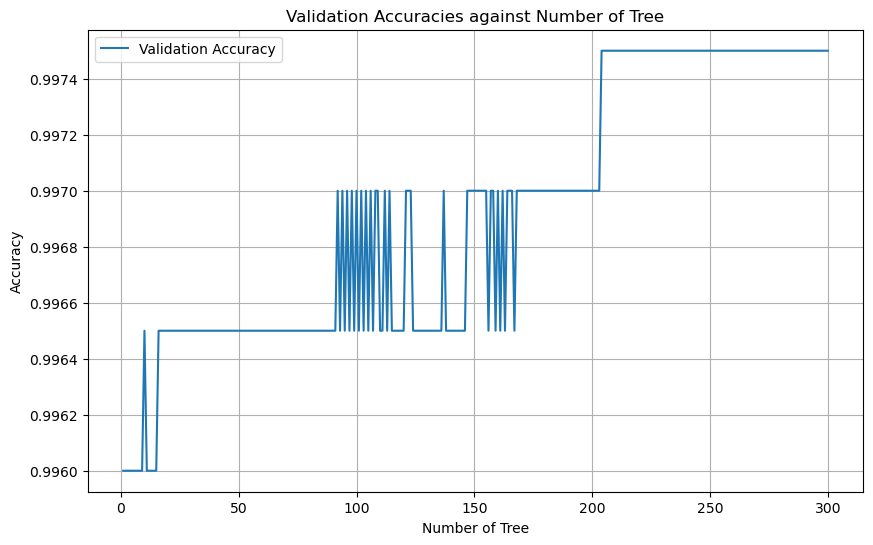

[-1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1]
Test Accuracy ADA Boost: 0.9981087470449173


In [28]:
import matplotlib.pyplot as plt

def plot_accuracies( val_accuracies):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Number of Tree')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracies against Number of Tree')
    plt.legend()
    plt.grid(True)
    plt.show()

def test_adaboost(classifiers, X_test, y_test):
    test_predictions = ada_boost_predict(classifiers, X_test, y_test)
    test_accuracy = np.mean(test_predictions == y_test)
    print(f"Test Accuracy ADA Boost: {test_accuracy}")

# Example usage
plot_accuracies( val_accuracies)
test_adaboost(classifiers, x_reduced_test, y_test)


In [24]:
tree, _ = classifiers[np.argmax(val_accuracies)]

In [30]:
prediction = np.array([predict(x, tree) for x in x_reduced_test],dtype = np.int64)
print("Test Accuracy on Best Tree ",np.mean(prediction == y_test))

Test Accuracy on Best Tree  0.6189125295508274


In [27]:
test_predictions = ada_boost_predict(classifiers, x_reduced_test, y_test)
np.mean(test_predictions == y_test)

[-1  1 -1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1
  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1]


0.9981087470449173